# Load packages

In [49]:
import re
import json
from pathlib import Path
import pandas as pd
import numpy as np

In [50]:
!pwd

/storage/users/job37yv/Projects/Cardiomyopathy/scripts


# Data Loading

In [57]:
import pandas as pd

# Path to your Excel file (relative to your scripts folder)
file_path = "../data/raw_data/Johannes_Version-2.xlsx"

# Load with header rows (the real header starts at row 3, so use header=2)
df_raw = pd.read_excel(file_path, sheet_name=0, header=0)

# Drop the first repeated header row
df_raw = df_raw.iloc[1:, :]

df_raw.head(30)


,Patients,"Group (1=diabetic neuropathy, 2=diabetes without neuropathy, 0=control)",diabetes type,age,sex,Duration of Disease (months),SNAP (sural nerve),HbA1c (%),NIS-LL,SAS,NPSI,IENFD(per mm),"NF155 periodicity, mean (±SD)","NF186 periodicity, mean (±SD)","Caspr1 periodicity , mean (±SD)"
1,DB28513,1,2,66.0,male,75,0,4.9,15,32,33,1.93,413.51 (±167),413.51(±167),532.12(±157)
2,DB45913,2,2,63.0,male,11,34.3,5.3,0,2,0,3.76,542.21 (±152),542.21(±152),189.21(±81)
3,DB67312,2,2,72.0,male,180,6.3,7.8,1,0,0,1.72,NaN,NaN,231.60(±92)
4,DB85312,1,2,70.0,male,18,3.1,7,13,1,5,1.06,387.41 (±160),387.41(±160),316(±145)
5,DB6213,2,2,54.0,male,144,13.4,7.1,0,12,0,3.38,226.49 (±58),226.49 (±58),299.43(±135)
6,DB10613,1,2,69.0,male,11,2,9.8,5,10,12,0.25,311.98587 (±107),311.98587 (±107),331.21(±136)
7,DB82112,1,2,61.0,male,1,6.5,6.8,2,2,0,1.21,275.00(±100),275.00(±100),314.86 (±156)
8,DB553/13,1,2,73.0,male,180,2.8,6.8,3,17,0,2.67,420.90 (±225),420.90 (±225),331.44 (±156)
9,DB1034/13,1,2,55.0,male,0,4,"6,1",23,17,34,0,600,600,600
10,DB1091/13,1,1,54.0,male,252,8.6,7.1,25,28,49,6.52,456(±153),456(±153),511.12(±147)


# Data cleaning

In [63]:
import pandas as pd
import numpy as np

# --- Load ---
file_path = "../data/raw_data/Johannes_Version-2.xlsx"
df = pd.read_excel(file_path, sheet_name=0, header=0)
df = df.iloc[1:, :]   # drop repeated header row

# --- Replace "Not Good ..." with 700 ---
df = df.replace(to_replace=r".*Not Good.*", value=500, regex=True)

# --- Rename columns to shorter names ---
df = df.rename(columns={
    "Patients": "patient_id",
    "Group (1=diabetic neuropathy, 2=diabetes without neuropathy, 0=control)(SFN)": "group",
    "diabetes type (LADA)": "diabetes_type",
    "Duration of Disease (months)": "duration_months",
    "SNAP (sural nerve)": "snap_sural_nerve",
    "HbA1c (%)": "hba1c_pct",
    "NIS-LL": "nis_ll",
    "SAS": "sas",
    "NPSI": "npsi",
    "IENFD(per mm)": "ienfd_per_mm",
    "NF155 periodicity (nm), mean": "nf155_mean_nm",
    "NF186 periodicity (nm), mean": "nf186_mean_nm",
    "Caspr1 periodicity (nm), mean": "caspr1_mean_nm"
})

# --- Convert numeric-looking columns ---
numeric_cols = [
    "age", "duration_months", "snap_sural_nerve",
    "hba1c_pct", "nis_ll", "sas", "npsi", "ienfd_per_mm",
    "nf155_mean_nm", "nf186_mean_nm", "caspr1_mean_nm"
]

def to_float(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x).replace(",", ".").strip()
    try:
        return float(s.split(" ")[0].split("(")[0])
    except:
        return np.nan

for col in numeric_cols:
    df[col] = df[col].apply(to_float)

# --- Binary encoding for sex ---
def clean_sex(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    if s.startswith("m"): return 1
    if s.startswith("f"): return 0
    return np.nan

df["sex"] = df["sex"].map(clean_sex)

# --- Drop rows with more than 3 NaNs ---
df = df[df.isna().sum(axis=1) <= 3].reset_index(drop=True)

# --- Example: one-hot encode categorical variables ---
#    (This will expand group and diabetes_type into dummy columns)
df_encoded = pd.get_dummies(df, columns=["group", "diabetes_type"], drop_first=True)

print("Shape after cleaning:", df.shape)
print("Shape after encoding:", df_encoded.shape)




KeyError: 'nf155_mean_nm'

In [66]:
import pandas as pd
import numpy as np
import re

# --- Load (keeping your current approach) ---
file_path = "../data/raw_data/Johannes_Version-2.xlsx"
df = pd.read_excel(file_path, sheet_name=0, header=0)
df = df.iloc[1:, :]   # drop repeated header row

# --- Replace "Not Good ..." with 500 (per your code/comment mismatch noted earlier) ---
df = df.replace(to_replace=r".*Not Good.*", value=500, regex=True)

# --- Normalize raw column names to match the "current headers changed" version you posted ---
def _norm(s: str) -> str:
    s = str(s)
    s = re.sub(r"\s+", " ", s).strip()   # collapse multiple spaces
    s = re.sub(r"\s+,", ",", s)          # remove space before commas: " ," -> ","
    return s

df.columns = [_norm(c) for c in df.columns]

# For reference, the current headers you showed (after normalization) should look like:
# "Patients",
# "Group (1=diabetic neuropathy, 2=diabetes without neuropathy, 0=control)",
# "diabetes type",
# "age",
# "sex",
# "Duration of Disease (months)",
# "SNAP (sural nerve)",
# "HbA1c (%)",
# "NIS-LL",
# "SAS",
# "NPSI",
# "IENFD(per mm)",
# "NF155 periodicity, mean (±SD)",
# "NF186 periodicity, mean (±SD)",
# "Caspr1 periodicity, mean (±SD)"

# --- Rename to shorter names (keys now match the normalized headers above) ---
df = df.rename(columns={
    "Patients": "patient_id",
    "Group (1=diabetic neuropathy, 2=diabetes without neuropathy, 0=control)": "group",
    "diabetes type": "diabetes_type",
    "age": "age",
    "sex": "sex",
    "Duration of Disease (months)": "duration_months",
    "SNAP (sural nerve)": "snap_sural_nerve",
    "HbA1c (%)": "hba1c_pct",
    "NIS-LL": "nis_ll",
    "SAS": "sas",
    "NPSI": "npsi",
    "IENFD(per mm)": "ienfd_per_mm",
    "NF155 periodicity, mean (±SD)": "nf155_mean_nm",
    "NF186 periodicity, mean (±SD)": "nf186_mean_nm",
    "Caspr1 periodicity, mean (±SD)": "caspr1_mean_nm"
})

# --- Convert numeric-looking columns ---
numeric_cols = [
    "age", "duration_months", "snap_sural_nerve",
    "hba1c_pct", "nis_ll", "sas", "npsi", "ienfd_per_mm",
    "nf155_mean_nm", "nf186_mean_nm", "caspr1_mean_nm"
]

def to_float(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x).replace(",", ".").strip()
    # take the first token before space/parenthesis (handles "413.51 (±167)")
    s = s.split(" ")[0].split("(")[0]
    try:
        return float(s)
    except:
        return np.nan

for col in numeric_cols:
    if col in df.columns:  # guard in case any column is missing
        df[col] = df[col].apply(to_float)

# --- Binary encoding for sex ---
def clean_sex(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    if s.startswith("m"): return 1
    if s.startswith("f"): return 0
    return np.nan

if "sex" in df.columns:
    df["sex"] = df["sex"].map(clean_sex)

# --- Drop rows with more than 3 NaNs ---
df = df[df.isna().sum(axis=1) <= 3].reset_index(drop=True)

# --- One-hot encode categorical variables (if present) ---
cats = [c for c in ["group", "diabetes_type"] if c in df.columns]
df_encoded = pd.get_dummies(df, columns=cats, drop_first=True) if cats else df.copy()

print("Cols after rename:", list(df.columns))
print("Shape after cleaning:", df.shape)
print("Shape after encoding:", df_encoded.shape)

df.head(20)

Cols after rename: ['patient_id', 'group', 'diabetes_type', 'age', 'sex', 'duration_months', 'snap_sural_nerve', 'hba1c_pct', 'nis_ll', 'sas', 'npsi', 'ienfd_per_mm', 'nf155_mean_nm', 'nf186_mean_nm', 'caspr1_mean_nm']
Shape after cleaning: (35, 15)
Shape after encoding: (35, 17)


,patient_id,group,diabetes_type,age,sex,duration_months,snap_sural_nerve,hba1c_pct,nis_ll,sas,npsi,ienfd_per_mm,nf155_mean_nm,nf186_mean_nm,caspr1_mean_nm
0,DB28513,1,2,66.0,1,75.0,0.00,4.9,15.0,32.0,33.0,1.93,413.51000,413.51000,532.12
1,DB45913,2,2,63.0,1,11.0,34.30,5.3,0.0,2.0,0.0,3.76,542.21000,542.21000,189.21
2,DB67312,2,2,72.0,1,180.0,6.30,7.8,1.0,0.0,0.0,1.72,NaN,NaN,231.60
3,DB85312,1,2,70.0,1,18.0,3.10,7.0,13.0,1.0,5.0,1.06,387.41000,387.41000,316.00
4,DB6213,2,2,54.0,1,144.0,13.40,7.1,0.0,12.0,0.0,3.38,226.49000,226.49000,299.43
5,DB10613,1,2,69.0,1,11.0,2.00,9.8,5.0,10.0,12.0,0.25,311.98587,311.98587,331.21
6,DB82112,1,2,61.0,1,1.0,6.50,6.8,2.0,2.0,0.0,1.21,275.00000,275.00000,314.86
7,DB553/13,1,2,73.0,1,180.0,2.80,6.8,3.0,17.0,0.0,2.67,420.90000,420.90000,331.44
8,DB1034/13,1,2,55.0,1,0.0,4.00,6.1,23.0,17.0,34.0,0.00,600.00000,600.00000,600.00
9,DB1091/13,1,1,54.0,1,252.0,8.60,7.1,25.0,28.0,49.0,6.52,456.00000,456.00000,511.12


## Impute NaN

In [67]:
# Function to impute missing periodicity values from the other two
def impute_from_others(row, target, others):
    if pd.isna(row[target]):
        for col in others:
            if not pd.isna(row[col]):
                return row[col]
    return row[target]

periodicity_cols = ["nf155_mean_nm", "nf186_mean_nm", "caspr1_mean_nm"]

for col in periodicity_cols:
    others = [c for c in periodicity_cols if c != col]
    df[col] = df.apply(lambda row: impute_from_others(row, col, others), axis=1)


In [69]:
df.head(30)

,patient_id,group,diabetes_type,age,sex,duration_months,snap_sural_nerve,hba1c_pct,nis_ll,sas,npsi,ienfd_per_mm,nf155_mean_nm,nf186_mean_nm,caspr1_mean_nm
0,DB28513,1,2,66.0,1,75.0,0.00,4.9,15.0,32.0,33.0,1.93,413.51000,413.51000,532.12
1,DB45913,2,2,63.0,1,11.0,34.30,5.3,0.0,2.0,0.0,3.76,542.21000,542.21000,189.21
2,DB67312,2,2,72.0,1,180.0,6.30,7.8,1.0,0.0,0.0,1.72,231.60000,231.60000,231.60
3,DB85312,1,2,70.0,1,18.0,3.10,7.0,13.0,1.0,5.0,1.06,387.41000,387.41000,316.00
4,DB6213,2,2,54.0,1,144.0,13.40,7.1,0.0,12.0,0.0,3.38,226.49000,226.49000,299.43
5,DB10613,1,2,69.0,1,11.0,2.00,9.8,5.0,10.0,12.0,0.25,311.98587,311.98587,331.21
6,DB82112,1,2,61.0,1,1.0,6.50,6.8,2.0,2.0,0.0,1.21,275.00000,275.00000,314.86
7,DB553/13,1,2,73.0,1,180.0,2.80,6.8,3.0,17.0,0.0,2.67,420.90000,420.90000,331.44
8,DB1034/13,1,2,55.0,1,0.0,4.00,6.1,23.0,17.0,34.0,0.00,600.00000,600.00000,600.00
9,DB1091/13,1,1,54.0,1,252.0,8.60,7.1,25.0,28.0,49.0,6.52,456.00000,456.00000,511.12


In [7]:
# Fill NaN in n_nodes_examined with 1
df["n_nodes_examined"] = df["n_nodes_examined"].fillna(1)

# Fill NaN in snap_sural_nerve with mean of the column
mean_snap = df["snap_sural_nerve"].mean(skipna=True)
df["snap_sural_nerve"] = df["snap_sural_nerve"].fillna(mean_snap)

print("Check remaining NaN counts:")
print(df.isna().sum())


Check remaining NaN counts:
Patients            0
group               0
diabetes_type       0
age                 0
sex                 0
duration_months     0
snap_sural_nerve    0
hba1c_pct           0
nis_ll              0
sas                 0
npsi                0
ienfd_per_mm        0
n_nodes_examined    0
nf155_mean_nm       0
nf186_mean_nm       0
caspr1_mean_nm      0
dtype: int64


In [70]:
df.head(38)

,patient_id,group,diabetes_type,age,sex,duration_months,snap_sural_nerve,hba1c_pct,nis_ll,sas,npsi,ienfd_per_mm,nf155_mean_nm,nf186_mean_nm,caspr1_mean_nm
0,DB28513,1,2,66.0,1,75.0,0.00,4.9,15.0,32.0,33.0,1.93,413.51000,413.51000,532.12
1,DB45913,2,2,63.0,1,11.0,34.30,5.3,0.0,2.0,0.0,3.76,542.21000,542.21000,189.21
2,DB67312,2,2,72.0,1,180.0,6.30,7.8,1.0,0.0,0.0,1.72,231.60000,231.60000,231.60
3,DB85312,1,2,70.0,1,18.0,3.10,7.0,13.0,1.0,5.0,1.06,387.41000,387.41000,316.00
4,DB6213,2,2,54.0,1,144.0,13.40,7.1,0.0,12.0,0.0,3.38,226.49000,226.49000,299.43
5,DB10613,1,2,69.0,1,11.0,2.00,9.8,5.0,10.0,12.0,0.25,311.98587,311.98587,331.21
6,DB82112,1,2,61.0,1,1.0,6.50,6.8,2.0,2.0,0.0,1.21,275.00000,275.00000,314.86
7,DB553/13,1,2,73.0,1,180.0,2.80,6.8,3.0,17.0,0.0,2.67,420.90000,420.90000,331.44
8,DB1034/13,1,2,55.0,1,0.0,4.00,6.1,23.0,17.0,34.0,0.00,600.00000,600.00000,600.00
9,DB1091/13,1,1,54.0,1,252.0,8.60,7.1,25.0,28.0,49.0,6.52,456.00000,456.00000,511.12


# Feature anaylsis


=== Predicting nf155_mean_nm ===
R² on test: -0.7722080729310947


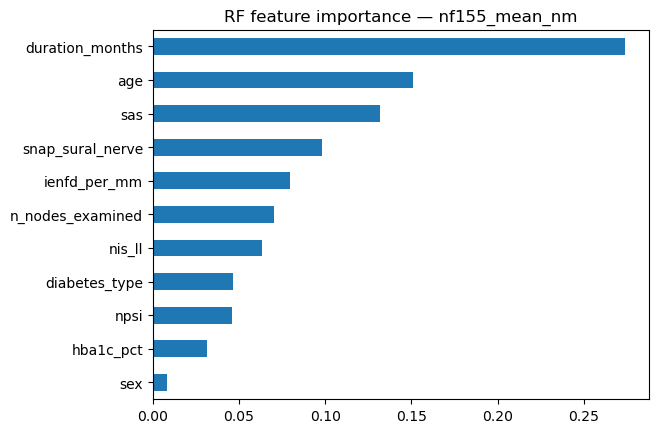

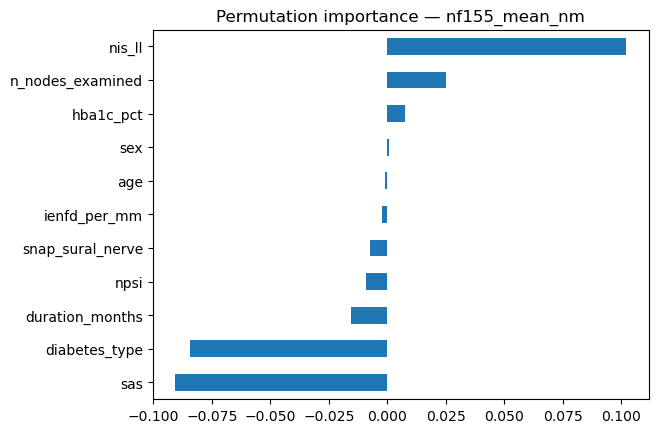

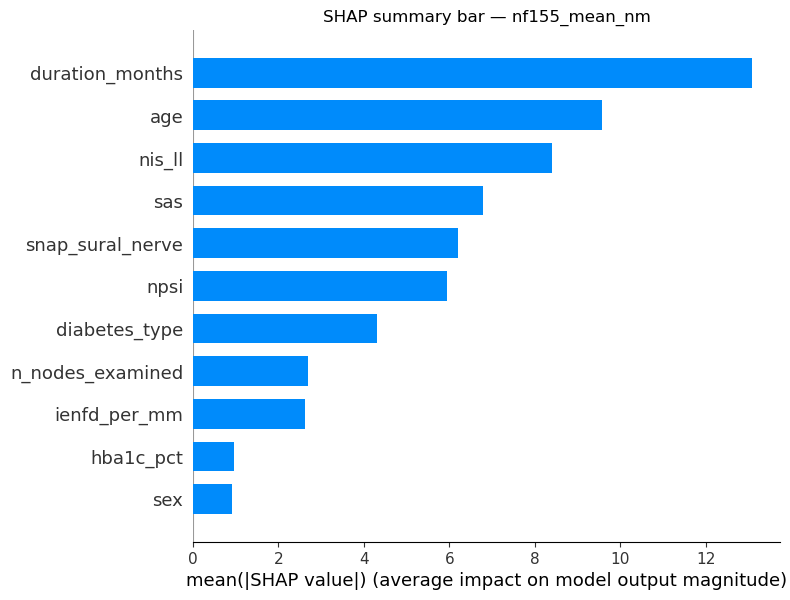

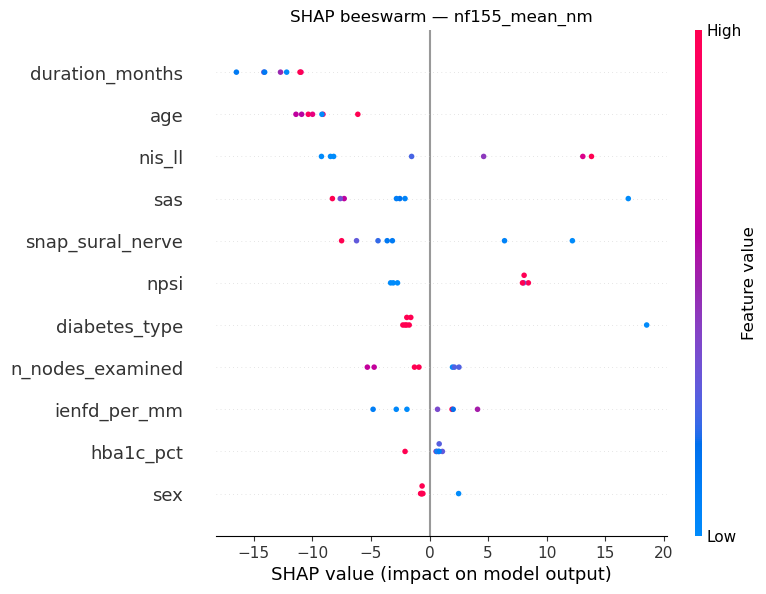


=== Predicting nf186_mean_nm ===
R² on test: -0.7722080729310947


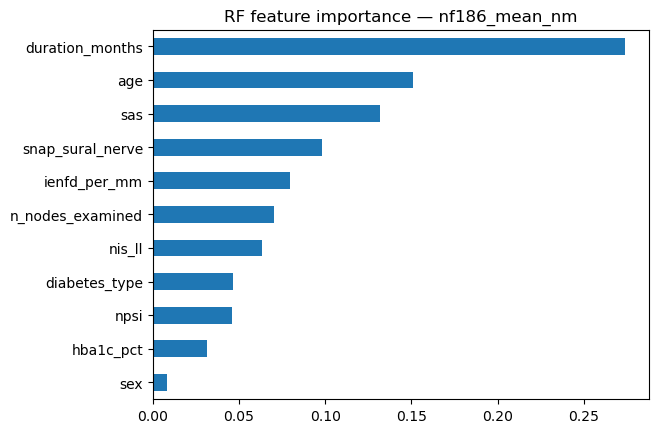

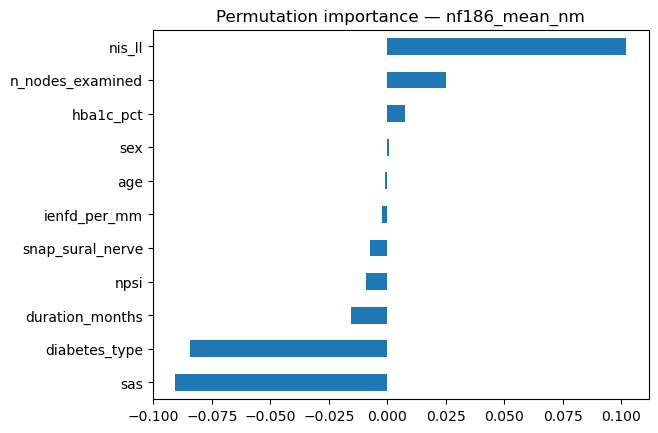

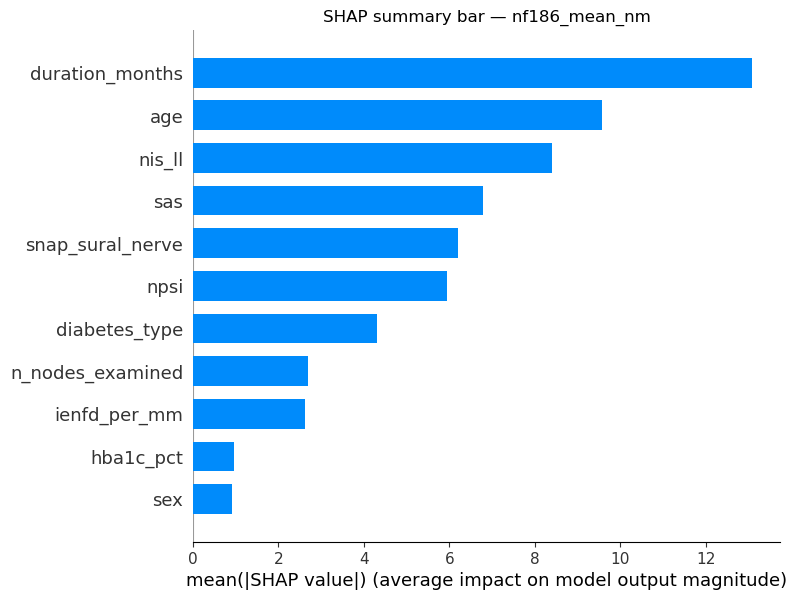

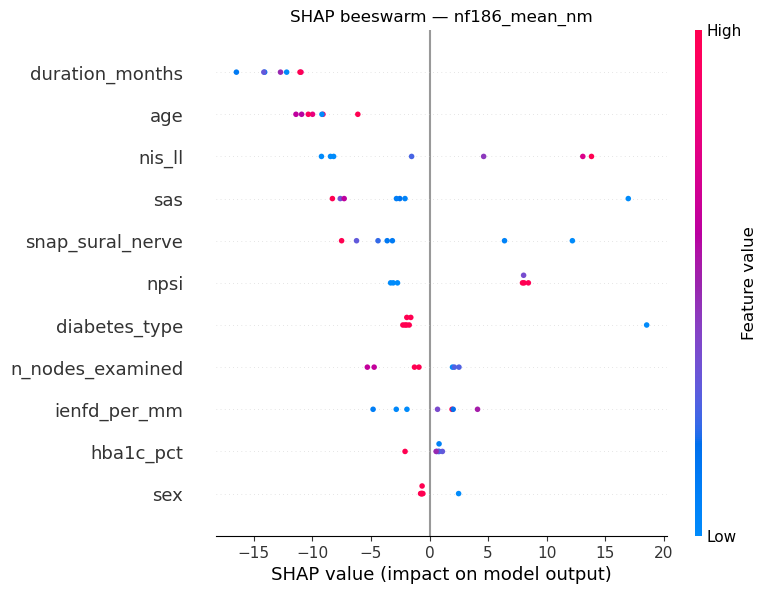


=== Predicting caspr1_mean_nm ===
R² on test: 0.025979769608599268


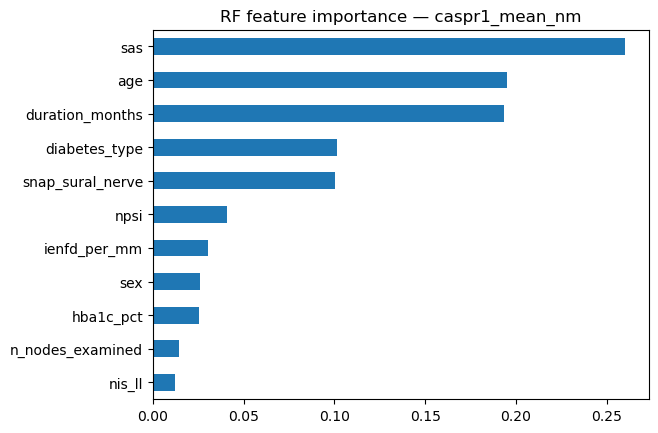

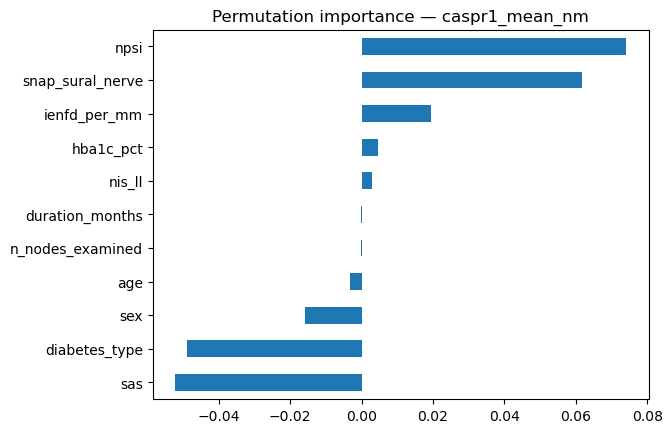

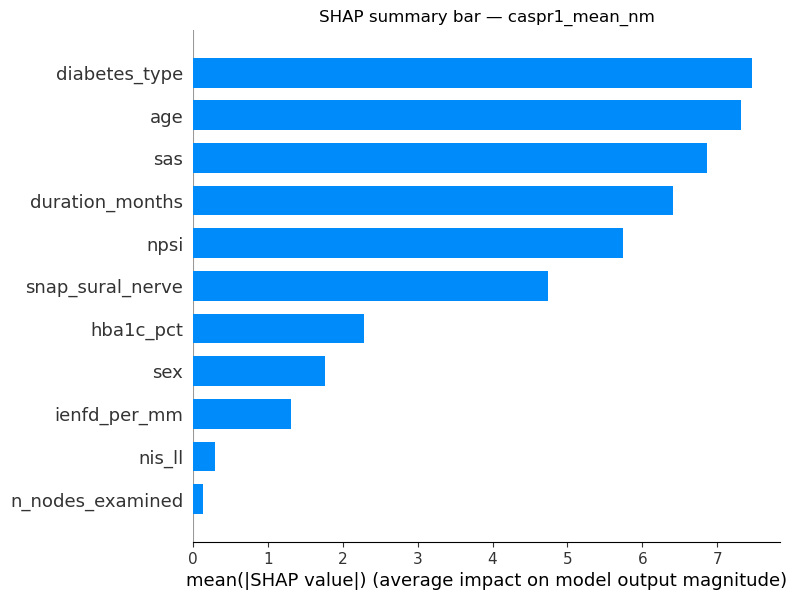

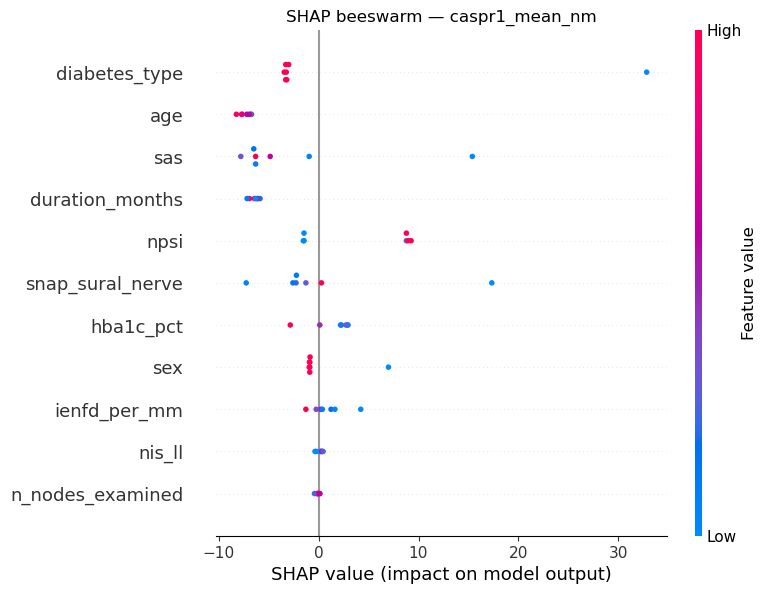

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt

# Features and targets
features = ["diabetes_type","age","sex","duration_months","snap_sural_nerve",
            "hba1c_pct","nis_ll","sas","npsi","ienfd_per_mm","n_nodes_examined"]
targets = ["nf155_mean_nm","nf186_mean_nm","caspr1_mean_nm"]

# Loop over targets
for target in targets:
    print(f"\n=== Predicting {target} ===")
    mask = df[target].notna()
    X = df.loc[mask, features]
    y = df.loc[mask, target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Pipeline with imputation
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestRegressor(n_estimators=400, random_state=42))
    ])

    # Fit model
    pipe.fit(X_train, y_train)
    r2 = pipe.score(X_test, y_test)
    print("R² on test:", r2)

    # --- 1. Built-in RF feature importance
    importances = pipe.named_steps["rf"].feature_importances_
    pd.Series(importances, index=features).sort_values(ascending=True).plot.barh()
    plt.title(f"RF feature importance — {target}")
    plt.show()

    # --- 2. Permutation importance
    perm = permutation_importance(pipe, X_test, y_test, n_repeats=30, random_state=42)
    pd.Series(perm.importances_mean, index=features).sort_values(ascending=True).plot.barh()
    plt.title(f"Permutation importance — {target}")
    plt.show()

    # --- 3. SHAP values
    explainer = shap.TreeExplainer(pipe.named_steps["rf"])
    X_test_imp = pipe.named_steps["imputer"].transform(X_test)
    X_test_imp = pd.DataFrame(X_test_imp, columns=features, index=X_test.index)

    shap_values = explainer.shap_values(X_test_imp)

    shap.summary_plot(shap_values, X_test_imp, plot_type="bar", show=False)
    plt.title(f"SHAP summary bar — {target}")
    plt.show()

    shap.summary_plot(shap_values, X_test_imp, show=False)
    plt.title(f"SHAP beeswarm — {target}")
    plt.show()


In [40]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt

# --- Setup output folder ---
outdir = Path("../analysis/feature-analysis")
outdir.mkdir(parents=True, exist_ok=True)

# Features and targets
features = ["diabetes_type","age","sex","duration_months","snap_sural_nerve",
            "hba1c_pct","nis_ll","sas","npsi","ienfd_per_mm","n_nodes_examined"]
targets = ["nf155_mean_nm","nf186_mean_nm","caspr1_mean_nm"]

all_results = []

for target in targets:
    print(f"\n=== Predicting {target} ===")
    mask = df[target].notna()
    X = df.loc[mask, features]
    y = df.loc[mask, target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Pipeline with imputation
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestRegressor(n_estimators=400, random_state=42))
    ])

    # Fit model
    pipe.fit(X_train, y_train)
    r2 = pipe.score(X_test, y_test)
    print("R² on test:", r2)

    # --- 1. RF built-in importance ---
    rf_importance = pd.Series(pipe.named_steps["rf"].feature_importances_, index=features)

    plt.figure()
    rf_importance.sort_values().plot.barh()
    plt.title(f"RF feature importance — {target}")
    plt.tight_layout()
    plt.savefig(outdir / f"rf_importance_{target}.png")
    plt.close()

    # --- 2. Permutation importance ---
    perm = permutation_importance(pipe, X_test, y_test, n_repeats=30, random_state=42)
    perm_importance = pd.Series(perm.importances_mean, index=features)

    plt.figure()
    perm_importance.sort_values().plot.barh()
    plt.title(f"Permutation importance — {target}")
    plt.tight_layout()
    plt.savefig(outdir / f"permutation_importance_{target}.png")
    plt.close()

    # --- 3. SHAP values ---
    explainer = shap.TreeExplainer(pipe.named_steps["rf"])
    X_test_imp = pipe.named_steps["imputer"].transform(X_test)
    X_test_imp = pd.DataFrame(X_test_imp, columns=features, index=X_test.index)
    shap_values = explainer.shap_values(X_test_imp)

    shap.summary_plot(shap_values, X_test_imp, plot_type="bar", show=False)
    plt.title(f"SHAP summary bar — {target}")
    plt.tight_layout()
    plt.savefig(outdir / f"shap_bar_{target}.png")
    plt.close()

    shap.summary_plot(shap_values, X_test_imp, show=False)
    plt.title(f"SHAP beeswarm — {target}")
    plt.tight_layout()
    plt.savefig(outdir / f"shap_beeswarm_{target}.png")
    plt.close()

    # --- Collect numeric results into a table ---
    shap_importance = np.abs(shap_values).mean(axis=0)
    shap_series = pd.Series(shap_importance, index=features)

    result_df = pd.DataFrame({
        "RF_importance": rf_importance,
        "Permutation_importance": perm_importance,
        "Mean_abs_SHAP": shap_series
    }).sort_values("Mean_abs_SHAP", ascending=False)

    result_df["target"] = target
    result_df["r2_test"] = r2

    # Save CSV for this target
    result_df.to_csv(outdir / f"feature_importance_{target}.csv")

    all_results.append(result_df)

# --- Merge all targets into one table ---
final_results = pd.concat(all_results)
final_results.to_csv(outdir / "feature_importance_all_targets.csv")

print(f"\nAnalysis finished. Results saved in: {outdir.resolve()}")



=== Predicting nf155_mean_nm ===
R² on test: -0.7722080729310947

=== Predicting nf186_mean_nm ===
R² on test: -0.7722080729310947

=== Predicting caspr1_mean_nm ===
R² on test: 0.025979769608599268

Analysis finished. Results saved in: /storage/users/job37yv/Projects/Cardiomyopathy/analysis/feature-analysis


# Feature corrleation heatmap 

In [41]:
# =========================
# 0) Setup & configuration
# =========================
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (optional) use seaborn for a nice heatmap if available
try:
    import seaborn as sns
    HAS_SNS = True
except:
    HAS_SNS = False

from scipy.stats import spearmanr
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text

# Where to save results
OUT = Path("../analysis/feature-analysis")
OUT.mkdir(parents=True, exist_ok=True)

# Feature sets
features = [
    "diabetes_type","age","sex","duration_months","snap_sural_nerve",
    "hba1c_pct","nis_ll","sas","npsi","ienfd_per_mm","n_nodes_examined"
]
targets = ["nf155_mean_nm","nf186_mean_nm","caspr1_mean_nm"]

# Quick sanity check
missing = [c for c in features+targets if c not in df.columns]
if missing:
    raise ValueError(f"These expected columns are missing from df: {missing}")

print("Rows:", len(df), "| saving outputs to:", OUT.resolve())


Rows: 21 | saving outputs to: /storage/users/job37yv/Projects/Cardiomyopathy/analysis/feature-analysis


,feature,target,spearman_r,p_value,n
30,npsi,caspr1_mean_nm,0.606201,0.003580,21
28,nis_ll,caspr1_mean_nm,0.265588,0.244587,21
29,sas,caspr1_mean_nm,0.240762,0.293114,21
25,duration_months,caspr1_mean_nm,0.162760,0.480864,21
23,age,caspr1_mean_nm,0.032584,0.888493,21
24,sex,caspr1_mean_nm,0.022503,0.922872,21
27,hba1c_pct,caspr1_mean_nm,-0.052100,0.822535,21
22,diabetes_type,caspr1_mean_nm,-0.053650,0.817342,21
32,n_nodes_examined,caspr1_mean_nm,-0.344629,0.126043,21
26,snap_sural_nerve,caspr1_mean_nm,-0.371457,0.097331,21


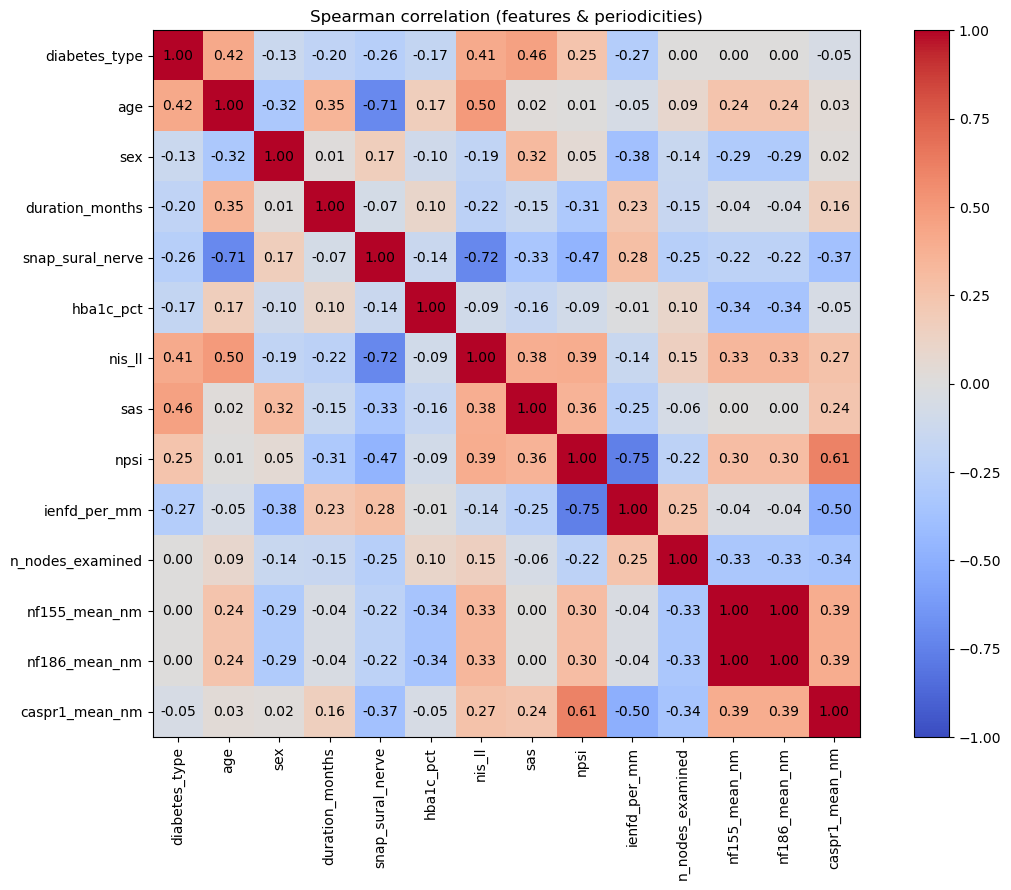

In [42]:
# ======================================
# 1) Spearman correlations (+ p-values)
# ======================================
def spearman_df(df, X_cols, y_cols):
    rows = []
    for y in y_cols:
        mask = df[y].notna()
        for x in X_cols:
            m2 = mask & df[x].notna()
            if m2.sum() < 5:
                r, p = np.nan, np.nan
            else:
                r, p = spearmanr(df.loc[m2, x], df.loc[m2, y])
            rows.append({"feature": x, "target": y, "spearman_r": r, "p_value": p, "n": int(m2.sum())})
    return pd.DataFrame(rows)

corr_tbl = spearman_df(df, features, targets)
corr_tbl.to_csv(OUT/"spearman_correlations.csv", index=False)
display(corr_tbl.sort_values(["target","spearman_r"], ascending=[True, False]).head(15))

# Heatmap (features + targets together)
corr_mat = df[features+targets].corr(method="spearman")
plt.figure(figsize=(12,9))
if HAS_SNS:
    sns.heatmap(corr_mat, annot=True, cmap="coolwarm", center=0)
else:
    plt.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(corr_mat.columns)), corr_mat.columns, rotation=90)
    plt.yticks(range(len(corr_mat.index)), corr_mat.index)
    for i in range(len(corr_mat)):
        for j in range(len(corr_mat)):
            plt.text(j, i, f"{corr_mat.values[i,j]:.2f}", ha="center", va="center", color="black")
plt.title("Spearman correlation (features & periodicities)")
plt.tight_layout()
plt.savefig(OUT/"spearman_heatmap.png", dpi=200)
plt.show()


In [44]:
# ==================================
# 2) Linear Regression with LOOCV
# ==================================
from sklearn.model_selection import LeaveOneOut

lin_results = []

for ycol in targets:
    mask = df[ycol].notna()
    X = df.loc[mask, features].copy()
    y = df.loc[mask, ycol].astype(float).copy()

    # Pipeline: standardize -> linear regression
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lin", LinearRegression())
    ])

    loo = LeaveOneOut()
    # LOOCV predictions
    y_pred = cross_val_predict(pipe, X, y, cv=loo)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    
    # Fit once on full data (to get coefficients you can interpret)
    pipe.fit(X, y)
    coefs = pd.Series(pipe.named_steps["lin"].coef_, index=features)

    print(f"[Linear LOOCV] {ycol}: R²={r2:.3f}, RMSE={rmse:.2f}")
    coef_tbl = coefs.sort_values(ascending=False).to_frame(name="coef")
    coef_tbl["abs_coef_rank"] = coef_tbl["coef"].abs().rank(ascending=False)
    coef_tbl.to_csv(OUT/f"linear_coefficients_{ycol}.csv")

    # Store summary row
    for f in features:
        lin_results.append({"target": ycol, "feature": f, "coef": coefs[f], "r2_loocv": r2, "rmse_loocv": rmse})

lin_results_df = pd.DataFrame(lin_results)
lin_results_df.to_csv(OUT/"linear_loocv_summary.csv", index=False)
display(lin_results_df.head(100))


[Linear LOOCV] nf155_mean_nm: R²=-0.700, RMSE=120.59
[Linear LOOCV] nf186_mean_nm: R²=-0.700, RMSE=120.59
[Linear LOOCV] caspr1_mean_nm: R²=0.059, RMSE=90.17


,target,feature,coef,r2_loocv,rmse_loocv
0,nf155_mean_nm,diabetes_type,-55.380660,-0.699910,120.585373
1,nf155_mean_nm,age,45.644338,-0.699910,120.585373
2,nf155_mean_nm,sex,-47.191468,-0.699910,120.585373
3,nf155_mean_nm,duration_months,14.788825,-0.699910,120.585373
4,nf155_mean_nm,snap_sural_nerve,66.915347,-0.699910,120.585373
5,nf155_mean_nm,hba1c_pct,-21.258994,-0.699910,120.585373
6,nf155_mean_nm,nis_ll,53.192351,-0.699910,120.585373
7,nf155_mean_nm,sas,9.532298,-0.699910,120.585373
8,nf155_mean_nm,npsi,6.827890,-0.699910,120.585373
9,nf155_mean_nm,ienfd_per_mm,-28.824871,-0.699910,120.585373


In [46]:
# ============================
# 3) LASSO (sparse predictors)
# ============================
lasso_results = []

for ycol in targets:
    mask = df[ycol].notna()
    X = df.loc[mask, features].copy()
    y = df.loc[mask, ycol].astype(float).copy()

    # Standardize + LASSO with LOOCV to select alpha
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", LassoCV(cv=LeaveOneOut(), random_state=42, max_iter=10000))
    ])
    pipe.fit(X, y)

    y_pred = cross_val_predict(pipe, X, y, cv=LeaveOneOut())
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)

    alphas = pipe.named_steps["lasso"].alphas_
    alpha_sel = pipe.named_steps["lasso"].alpha_
    coefs = pd.Series(pipe.named_steps["lasso"].coef_, index=features)

    print(f"[LASSO LOOCV] {ycol}: R²={r2:.3f}, RMSE={rmse:.2f}, alpha={alpha_sel:.4g}")
    lasso_tbl = coefs.sort_values(ascending=False).to_frame(name="coef")
    lasso_tbl.to_csv(OUT/f"lasso_coefficients_{ycol}.csv")

    for f in features:
        lasso_results.append({"target": ycol, "feature": f, "lasso_coef": coefs[f], "r2_loocv": r2,
                              "rmse_loocv": rmse, "alpha": alpha_sel})

lasso_results_df = pd.DataFrame(lasso_results)
lasso_results_df.to_csv(OUT/"lasso_loocv_summary.csv", index=False)
display(lasso_results_df.head(50))


[LASSO LOOCV] nf155_mean_nm: R²=-0.620, RMSE=117.72, alpha=40.7
[LASSO LOOCV] nf186_mean_nm: R²=-0.620, RMSE=117.72, alpha=40.7
[LASSO LOOCV] caspr1_mean_nm: R²=-0.180, RMSE=101.00, alpha=1.173


,target,feature,lasso_coef,r2_loocv,rmse_loocv,alpha
0,nf155_mean_nm,diabetes_type,-0.000000,-0.619990,117.716657,40.701864
1,nf155_mean_nm,age,0.000000,-0.619990,117.716657,40.701864
2,nf155_mean_nm,sex,-0.000000,-0.619990,117.716657,40.701864
3,nf155_mean_nm,duration_months,0.000000,-0.619990,117.716657,40.701864
4,nf155_mean_nm,snap_sural_nerve,0.000000,-0.619990,117.716657,40.701864
5,nf155_mean_nm,hba1c_pct,-0.000000,-0.619990,117.716657,40.701864
6,nf155_mean_nm,nis_ll,0.000000,-0.619990,117.716657,40.701864
7,nf155_mean_nm,sas,0.000000,-0.619990,117.716657,40.701864
8,nf155_mean_nm,npsi,0.000000,-0.619990,117.716657,40.701864
9,nf155_mean_nm,ienfd_per_mm,0.000000,-0.619990,117.716657,40.701864


In [23]:
# ==================================================
# 4) Binary classification + simple cutoffs (tree)
# ==================================================
# Turn each target into High(1)/Low(0) by median split, then:
# - Logistic Regression (LOOCV AUC & accuracy)
# - Shallow Decision Tree (depth=2) to extract simple thresholds

clf_rows = []

for ycol in targets:
    mask = df[ycol].notna()
    X = df.loc[mask, features].copy()
    y_raw = df.loc[mask, ycol].astype(float).copy()

    # median split
    thresh = y_raw.median()
    y = (y_raw >= thresh).astype(int)

    # logistic regression (with standardization)
    logit = Pipeline([
        ("scaler", StandardScaler()),
        ("logit", LogisticRegression(max_iter=2000, solver="liblinear"))
    ])

    # LOOCV predictions (probabilities for AUC)
    loo = LeaveOneOut()
    y_prob = cross_val_predict(logit, X, y, cv=loo, method="predict_proba")[:,1]
    y_pred = (y_prob >= 0.5).astype(int)
    try:
        auc = roc_auc_score(y, y_prob)
    except:
        auc = np.nan
    acc = accuracy_score(y, y_pred)

    print(f"[Logistic LOOCV] {ycol} High(>=median): AUC={auc:.3f}, Acc={acc:.2f} (thr={thresh:.2f})")

    # fit on all to get interpretable coefficients
    logit.fit(X, y)
    coefs = pd.Series(logit.named_steps["logit"].coef_[0], index=features).sort_values(ascending=False)
    coefs.to_csv(OUT/f"logistic_coefficients_{ycol}_median_split.csv")

    # tiny decision tree for cutoffs
    tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42)
    tree.fit(X, y)
    rules = export_text(tree, feature_names=list(features))
    with open(OUT/f"decision_tree_rules_{ycol}_median_split.txt","w") as f:
        f.write(rules)

    print(f"Decision Tree rules for {ycol}:\n{rules}")

    clf_rows.append({"target": ycol, "median_threshold": thresh, "auc_loocv": auc, "acc_loocv": acc})

clf_summary = pd.DataFrame(clf_rows)
clf_summary.to_csv(OUT/"classification_median_split_summary.csv", index=False)
display(clf_summary)


[Logistic LOOCV] nf155_mean_nm High(>=median): AUC=0.618, Acc=0.57 (thr=317.91)
Decision Tree rules for nf155_mean_nm:
|--- nis_ll <= 8.00
|   |--- age <= 72.50
|   |   |--- class: 0
|   |--- age >  72.50
|   |   |--- class: 1
|--- nis_ll >  8.00
|   |--- class: 1

[Logistic LOOCV] nf186_mean_nm High(>=median): AUC=0.618, Acc=0.57 (thr=317.91)
Decision Tree rules for nf186_mean_nm:
|--- nis_ll <= 8.00
|   |--- age <= 72.50
|   |   |--- class: 0
|   |--- age >  72.50
|   |   |--- class: 1
|--- nis_ll >  8.00
|   |--- class: 1

[Logistic LOOCV] caspr1_mean_nm High(>=median): AUC=0.491, Acc=0.52 (thr=313.31)
Decision Tree rules for caspr1_mean_nm:
|--- ienfd_per_mm <= 2.85
|   |--- hba1c_pct <= 7.45
|   |   |--- class: 1
|   |--- hba1c_pct >  7.45
|   |   |--- class: 0
|--- ienfd_per_mm >  2.85
|   |--- hba1c_pct <= 7.55
|   |   |--- class: 0
|   |--- hba1c_pct >  7.55
|   |   |--- class: 1



,target,median_threshold,auc_loocv,acc_loocv
0,nf155_mean_nm,317.91,0.618182,0.571429
1,nf186_mean_nm,317.91,0.618182,0.571429
2,caspr1_mean_nm,313.31,0.490909,0.523810


# =======================================================
# (Optional) Simple regression cutoffs with tiny tree reg
# =======================================================
# Fit a very shallow DecisionTreeRegressor to each continuous target
# to read off the *most salient thresholds* (e.g. age < 68.5, SAS > 7.5).

cutoff_rows = []
for ycol in targets:
    mask = df[ycol].notna()
    X = df.loc[mask, features].copy()
    y = df.loc[mask, ycol].astype(float).copy()

    # small tree to expose thresholds
    tre = DecisionTreeRegressor(max_depth=2, min_samples_leaf=2, random_state=42)
    tre.fit(X, y)

    txt = export_text(tre, feature_names=list(features), decimals=2)
    with open(OUT/f"regression_tree_cutoffs_{ycol}.txt","w") as f:
        f.write(txt)

    print(f"[TreeReg cutoffs] {ycol}\n{txt}\n")
    cutoff_rows.append({"target": ycol, "tree_rules": txt})

_ = pd.DataFrame(cutoff_rows)
print("Saved rule texts to:", OUT.resolve())


# Umap, non parametric testing

## Setup

In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import spearmanr, mannwhitneyu, kruskal
from statsmodels.stats.multitest import multipletests


In [10]:


# optional pretties
try:
    import seaborn as sns
    HAS_SNS = True
except Exception:
    HAS_SNS = False

# UMAP is optional; we fall back to PCA if missing
try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False


OUT = Path("../analysis/feature-analysis")
OUT.mkdir(parents=True, exist_ok=True)

# ==== set your columns (short names as in your cleaned df) ====
features = [
    "diabetes_type","age","sex","duration_months","snap_sural_nerve",
    "hba1c_pct","nis_ll","sas","npsi","ienfd_per_mm","n_nodes_examined"
]
targets  = ["nf155_mean_nm","nf186_mean_nm","caspr1_mean_nm"]

# basic check
missing = [c for c in features+targets if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in df: {missing}")

print("N rows:", len(df), " | saving to:", OUT.resolve())


N rows: 21  | saving to: /storage/users/job37yv/Projects/Cardiomyopathy/analysis/feature-analysis


## Spearman correlation heatmap (features ↔ periodicities)

,feature,target,spearman_r,p_value,n
30,npsi,caspr1_mean_nm,0.606201,0.003580,21
28,nis_ll,caspr1_mean_nm,0.265588,0.244587,21
29,sas,caspr1_mean_nm,0.240762,0.293114,21
25,duration_months,caspr1_mean_nm,0.162760,0.480864,21
23,age,caspr1_mean_nm,0.032584,0.888493,21
24,sex,caspr1_mean_nm,0.022503,0.922872,21
27,hba1c_pct,caspr1_mean_nm,-0.052100,0.822535,21
22,diabetes_type,caspr1_mean_nm,-0.053650,0.817342,21
32,n_nodes_examined,caspr1_mean_nm,-0.344629,0.126043,21
26,snap_sural_nerve,caspr1_mean_nm,-0.371457,0.097331,21


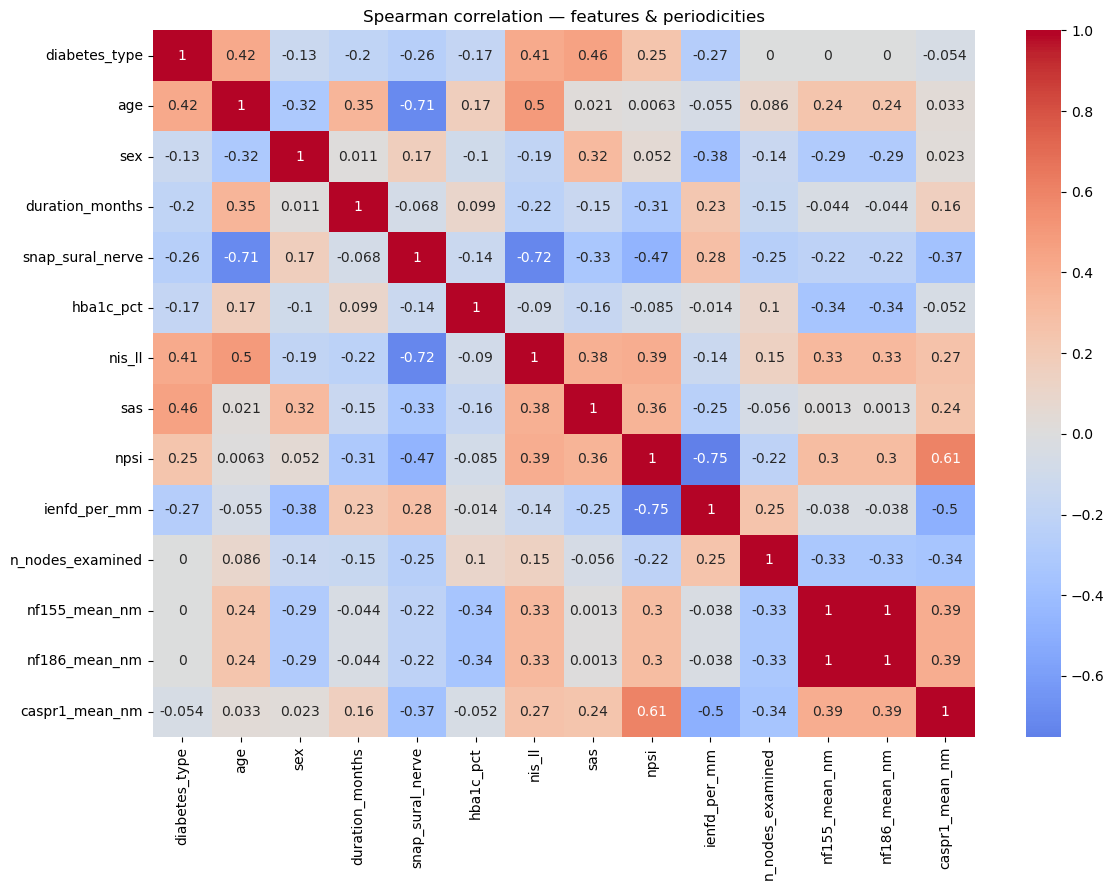

In [11]:
# pairwise Spearman (feature vs target), with p-values
rows = []
for y in targets:
    for x in features:
        mask = df[x].notna() & df[y].notna()
        if mask.sum() >= 5:
            r, p = spearmanr(df.loc[mask, x], df.loc[mask, y])
        else:
            r, p = np.nan, np.nan
        rows.append({"feature": x, "target": y, "spearman_r": r, "p_value": p, "n": int(mask.sum())})

corr_tbl = pd.DataFrame(rows)
corr_tbl.to_csv(OUT / "spearman_feature_to_periodicity.csv", index=False)
display(corr_tbl.sort_values(["target","spearman_r"], ascending=[True, False]).head(20))

# heatmap matrix (features+targets together, Spearman)
corr_mat = df[features+targets].corr(method="spearman")
plt.figure(figsize=(12,9))
if HAS_SNS:
    sns.heatmap(corr_mat, annot=True, cmap="coolwarm", center=0)
else:
    plt.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(corr_mat.columns)), corr_mat.columns, rotation=90)
    plt.yticks(range(len(corr_mat.index)), corr_mat.index)
plt.title("Spearman correlation — features & periodicities")
plt.tight_layout()
plt.savefig(OUT / "spearman_heatmap_features_targets.png", dpi=200)
plt.show()


## UMAP (or PCA fallback) on clinical features, colored by periodicities

/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


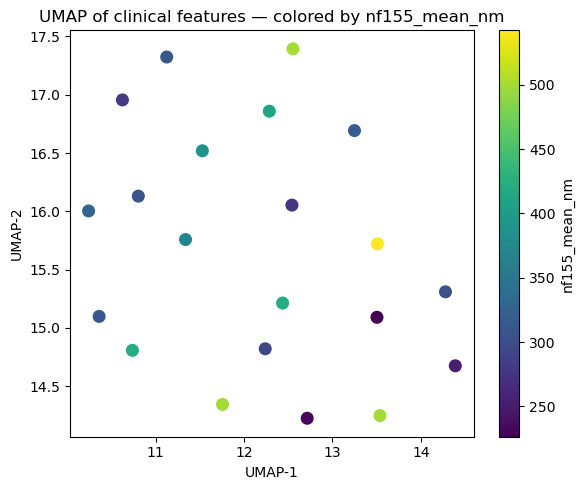

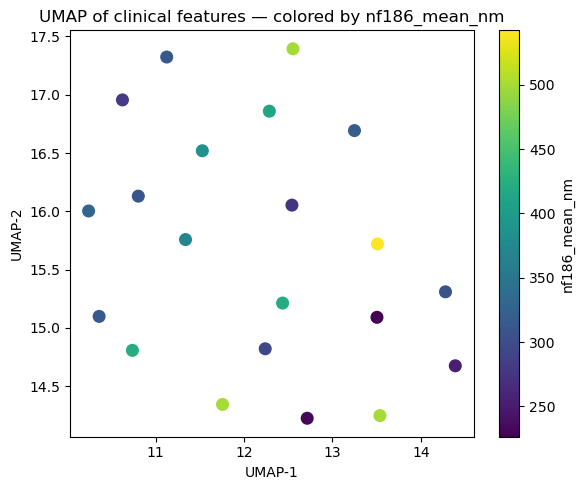

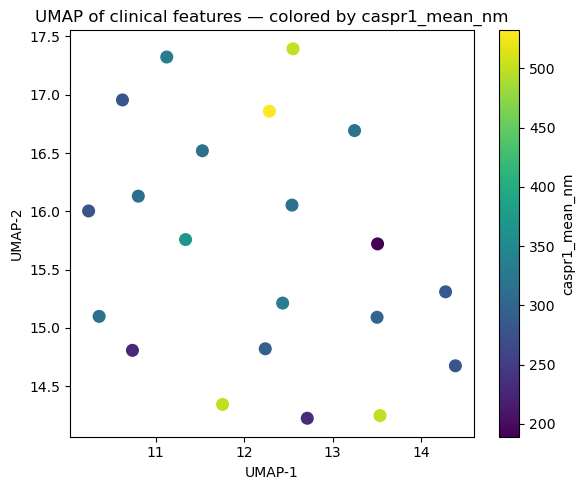

In [12]:
# build feature matrix (standardize numeric scale)
X = df[features].copy()
X = X.fillna(X.median(numeric_only=True))  # light imputation for visualization
X_scaled = StandardScaler().fit_transform(X)

if HAS_UMAP:
    reducer = umap.UMAP(n_neighbors=7, min_dist=0.3, random_state=42)
    emb = reducer.fit_transform(X_scaled)
    emb_name = "umap"
else:
    pca = PCA(n_components=2, random_state=42)
    emb = pca.fit_transform(X_scaled)
    emb_name = "pca"

emb_df = pd.DataFrame(emb, columns=["dim1","dim2"], index=df.index)
viz = pd.concat([emb_df, df[targets]], axis=1)

for y in targets:
    plt.figure(figsize=(6,5))
    sc = plt.scatter(viz["dim1"], viz["dim2"], c=viz[y], s=70)
    plt.xlabel(f"{emb_name.upper()}-1")
    plt.ylabel(f"{emb_name.upper()}-2")
    plt.title(f"{emb_name.upper()} of clinical features — colored by {y}")
    cb = plt.colorbar(sc)
    cb.set_label(y)
    plt.tight_layout()
    plt.savefig(OUT / f"{emb_name}_colored_by_{y}.png", dpi=200)
    plt.show()


##  Non-parametric tests (Spearman / Mann–Whitney / Kruskal–Wallis) with FDR

In [15]:
# --- Nonparametric association tests with FDR correction ---
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import spearmanr, mannwhitneyu, kruskal
from statsmodels.stats.multitest import multipletests

# Output folder (adjust if you use a different one)
OUT = Path("../analysis/feature-analysis")
OUT.mkdir(parents=True, exist_ok=True)

def is_binary_series(s: pd.Series) -> bool:
    vals = pd.Series(s.dropna().unique())
    return set(vals) <= {0, 1} or len(vals) == 2

results = []

for y in targets:
    yv = df[y].astype(float)

    for x in features:
        xv = df[x]
        mask = yv.notna() & xv.notna()
        if mask.sum() < 5:
            continue

        # Choose test:
        # - Binary predictor -> Mann–Whitney (y by groups of x)
        # - Small categorical (3–6 unique) -> Kruskal–Wallis
        # - Otherwise -> Spearman
        unique_x = xv[mask].nunique()
        if is_binary_series(xv[mask]):
            # Use the two unique values to define groups
            levels = list(xv[mask].unique())
            g0 = yv[mask][xv[mask] == levels[0]]
            g1 = yv[mask][xv[mask] == levels[1]]
            if len(g0) >= 2 and len(g1) >= 2:
                stat, p = mannwhitneyu(g0, g1, alternative="two-sided")
                test = "Mann-Whitney (y ~ binary x)"
                eff = float(np.median(g1) - np.median(g0))  # median diff as effect size
            else:
                stat, p, eff, test = np.nan, np.nan, np.nan, "Mann-Whitney (insufficient n)"
        elif 3 <= unique_x <= 6 and pd.api.types.is_integer_dtype(xv.dropna()):
            # Treat as small categorical
            groups = [yv[mask][xv[mask] == k] for k in xv[mask].dropna().unique()]
            if all(len(g) >= 2 for g in groups):
                stat, p = kruskal(*groups)
                test = "Kruskal-Wallis (y ~ categorical x)"
                eff = float(np.max([np.median(g) for g in groups]) - np.min([np.median(g) for g in groups]))
            else:
                stat, p, eff, test = np.nan, np.nan, np.nan, "Kruskal (insufficient n)"
        else:
            # Continuous/ordinal
            r, p = spearmanr(xv[mask], yv[mask])
            stat, eff, test = r, r, "Spearman (y ~ continuous x)"

        results.append({
            "target": y,
            "feature": x,
            "test": test,
            "stat_or_r": stat,
            "effect_size": eff,
            "p_value": p,
            "n": int(mask.sum()),
            "x_unique": int(unique_x),
        })

res = pd.DataFrame(results)

# --- FDR (Benjamini–Hochberg) per target (robust assignment) ---
res["p_fdr"] = np.nan
for y in targets:
    sub_idx = res.index[res["target"] == y]          # rows for this target
    pvals   = res.loc[sub_idx, "p_value"]            # Series aligned to sub_idx
    valid   = pvals.notna()
    if valid.sum() >= 1:
        _, pfdr, _, _ = multipletests(pvals[valid].values, method="fdr_bh")
        res.loc[sub_idx[valid], "p_fdr"] = pfdr

# Sort for readability: by target, then FDR p, then raw p, then |effect_size| desc
res_sorted = res.copy()
res_sorted["abs_effect_size"] = res_sorted["effect_size"].abs()
res_sorted = res_sorted.sort_values(
    ["target", "p_fdr", "p_value", "abs_effect_size"],
    ascending=[True, True, True, False]
)

# Save & display
out_file = OUT / "nonparametric_tests_summary.csv"
res_sorted.to_csv(out_file, index=False)
print(f"Saved: {out_file}")
res_sorted.head(30)


Saved: ../analysis/feature-analysis/nonparametric_tests_summary.csv


,target,feature,test,stat_or_r,effect_size,p_value,n,x_unique,p_fdr,abs_effect_size
30,caspr1_mean_nm,npsi,Spearman (y ~ continuous x),0.606201,0.606201,0.003580,21,6,0.039377,0.606201
31,caspr1_mean_nm,ienfd_per_mm,Spearman (y ~ continuous x),-0.497561,-0.497561,0.021727,21,20,0.119501,0.497561
26,caspr1_mean_nm,snap_sural_nerve,Spearman (y ~ continuous x),-0.371457,-0.371457,0.097331,21,16,0.346619,0.371457
32,caspr1_mean_nm,n_nodes_examined,Spearman (y ~ continuous x),-0.344629,-0.344629,0.126043,21,4,0.346619,0.344629
28,caspr1_mean_nm,nis_ll,Spearman (y ~ continuous x),0.265588,0.265588,0.244587,21,12,0.537375,0.265588
29,caspr1_mean_nm,sas,Spearman (y ~ continuous x),0.240762,0.240762,0.293114,21,11,0.537375,0.240762
25,caspr1_mean_nm,duration_months,Spearman (y ~ continuous x),0.162760,0.162760,0.480864,21,17,0.755644,0.162760
27,caspr1_mean_nm,hba1c_pct,Spearman (y ~ continuous x),-0.052100,-0.052100,0.822535,21,16,0.959870,0.052100
22,caspr1_mean_nm,diabetes_type,Mann-Whitney (y ~ binary x),17.000000,77.145000,0.857195,21,2,0.959870,77.145000
23,caspr1_mean_nm,age,Spearman (y ~ continuous x),0.032584,0.032584,0.888493,21,16,0.959870,0.032584


## Bootstrap stability of associations

In [18]:
from scipy.stats import spearmanr, kruskal
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)

def bootstrap_spearman(x, y, B=1000):
    # Returns: median_r, (ci_low, ci_high), sign_consistency
    idx = np.where(x.notna() & y.notna())[0]
    if len(idx) < 5:
        return np.nan, (np.nan, np.nan), np.nan

    vals = []
    for _ in range(B):
        b = rng.choice(idx, size=len(idx), replace=True)
        xb, yb = x.iloc[b], y.iloc[b]
        # skip if either side is constant (spearman undefined)
        if xb.nunique() < 2 or yb.nunique() < 2:
            continue
        r, p = spearmanr(xb, yb)
        if np.isfinite(r):
            vals.append(r)

    if len(vals) == 0:
        return np.nan, (np.nan, np.nan), np.nan

    vals = np.array(vals)
    return np.median(vals), (np.percentile(vals, 2.5), np.percentile(vals, 97.5)), float((vals > 0).mean())


def bootstrap_median_diff(x_bin, y, B=1000):
    """
    Binary predictor x_bin (two levels). Returns:
    median_diff (g1 - g0), (ci_low, ci_high), sign_consistency
    """
    idx = np.where(x_bin.notna() & y.notna())[0]
    if len(idx) < 5:
        return np.nan, (np.nan, np.nan), np.nan

    # global levels (ensure truly binary overall)
    global_levels = sorted(pd.unique(x_bin.iloc[idx]))
    if len(global_levels) != 2:
        return np.nan, (np.nan, np.nan), np.nan

    diffs = []
    for _ in range(B):
        b = rng.choice(idx, size=len(idx), replace=True)
        xb, yb = x_bin.iloc[b], y.iloc[b]
        # resample might collapse to a single level
        lvls = sorted(pd.unique(xb))
        if len(lvls) != 2:
            continue
        g0 = yb[xb == lvls[0]]
        g1 = yb[xb == lvls[1]]
        # require at least 2 per group for a stable median
        if len(g0) < 2 or len(g1) < 2:
            continue
        diffs.append(np.median(g1) - np.median(g0))

    if len(diffs) == 0:
        return np.nan, (np.nan, np.nan), np.nan

    diffs = np.array(diffs)
    return np.median(diffs), (np.percentile(diffs, 2.5), np.percentile(diffs, 97.5)), float((diffs > 0).mean())


def bootstrap_kruskal(x_cat, y, B=1000):
    """
    Small categorical predictor (>2 levels). Returns:
    fraction of resamples with Kruskal p < 0.05
    """
    idx = np.where(x_cat.notna() & y.notna())[0]
    if len(idx) < 6:
        return np.nan

    frac_sig = []
    for _ in range(B):
        b = rng.choice(idx, size=len(idx), replace=True)
        xb, yb = x_cat.iloc[b], y.iloc[b]
        lvls = pd.unique(xb.dropna())
        # need at least 3 groups with at least 2 samples each
        groups = [yb[xb == k] for k in lvls]
        groups = [g for g in groups if len(g) >= 2]
        if len(groups) < 3:
            continue
        try:
            _, p = kruskal(*groups)
            if np.isfinite(p):
                frac_sig.append(p < 0.05)
        except Exception:
            continue

    if len(frac_sig) == 0:
        return np.nan

    return float(np.mean(frac_sig))


# -----------------------------
# Run bootstrap stability table
# -----------------------------
boot_rows = []
for y in targets:
    yv = df[y].astype(float)

    for x in features:
        xv = df[x]

        if is_binary_series(xv):
            est, ci, pos = bootstrap_median_diff(xv, yv, B=1000)
            boot_rows.append({
                "target": y, "feature": x, "bootstrap_metric": "median_diff (g1-g0)",
                "estimate": est, "ci_low": ci[0], "ci_high": ci[1],
                "sign_consistency": pos
            })
        elif 3 <= xv.nunique(dropna=True) <= 6 and (xv.dropna().dtype.kind in "biu"):
            frac_sig = bootstrap_kruskal(xv, yv, B=1000)
            boot_rows.append({
                "target": y, "feature": x, "bootstrap_metric": "Kruskal p<0.05 fraction",
                "estimate": frac_sig, "ci_low": np.nan, "ci_high": np.nan,
                "sign_consistency": np.nan
            })
        else:
            est, ci, pos = bootstrap_spearman(xv, yv, B=1000)
            boot_rows.append({
                "target": y, "feature": x, "bootstrap_metric": "Spearman rho",
                "estimate": est, "ci_low": ci[0], "ci_high": ci[1],
                "sign_consistency": pos
            })

boot = pd.DataFrame(boot_rows).sort_values(
    ["target", "bootstrap_metric", "estimate"], ascending=[True, True, False]
)
boot.to_csv(OUT / "bootstrap_stability_summary.csv", index=False)
display(boot.head(30))


,target,feature,bootstrap_metric,estimate,ci_low,ci_high,sign_consistency
30,caspr1_mean_nm,npsi,Spearman rho,0.607029,0.209788,0.836785,0.998000
28,caspr1_mean_nm,nis_ll,Spearman rho,0.284239,-0.264783,0.674398,0.860000
29,caspr1_mean_nm,sas,Spearman rho,0.243119,-0.308081,0.703160,0.815000
25,caspr1_mean_nm,duration_months,Spearman rho,0.158559,-0.333127,0.600071,0.733000
23,caspr1_mean_nm,age,Spearman rho,0.042909,-0.422376,0.490347,0.575000
27,caspr1_mean_nm,hba1c_pct,Spearman rho,-0.062332,-0.577529,0.456276,0.405000
32,caspr1_mean_nm,n_nodes_examined,Spearman rho,-0.347223,-0.732923,0.138725,0.083000
26,caspr1_mean_nm,snap_sural_nerve,Spearman rho,-0.366824,-0.748887,0.146095,0.072000
31,caspr1_mean_nm,ienfd_per_mm,Spearman rho,-0.497700,-0.784463,-0.072241,0.009000
24,caspr1_mean_nm,sex,median_diff (g1-g0),-2.810000,-208.650000,89.050000,0.469880


# Focus hypothesis testing

## Setup

In [20]:
## from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# optional pretties / tools
try:
    import seaborn as sns
    HAS_SNS = True
except:
    HAS_SNS = False

try:
    import umap
    HAS_UMAP = True
except:
    HAS_UMAP = False

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from scipy.stats import spearmanr

OUT = Path("../analysis/feature-analysis")
OUT.mkdir(parents=True, exist_ok=True)

assert set(["npsi","ienfd_per_mm","age","duration_months","caspr1_mean_nm"]).issubset(df.columns), "Missing columns"
print("n rows:", len(df))


n rows: 21


## Focused hypothesis tests (Caspr1 ~ NPSI, Caspr1 ~ IENFD)

In [21]:
rows = []
for x in ["npsi","ienfd_per_mm"]:
    mask = df["caspr1_mean_nm"].notna() & df[x].notna()
    r, p = spearmanr(df.loc[mask, x], df.loc[mask, "caspr1_mean_nm"])
    rows.append({"feature": x, "spearman_r": r, "p_value": p, "n": int(mask.sum())})

fx_tbl = pd.DataFrame(rows)
fx_tbl.to_csv(OUT/"focused_spearman_caspr1.csv", index=False)
fx_tbl


,feature,spearman_r,p_value,n
0,npsi,0.606201,0.003580,21
1,ienfd_per_mm,-0.497561,0.021727,21


## Partial Spearman (Caspr1 ~ NPSI | age + duration), optional also with IENFD

In [37]:
def partial_spearman(y, x, covars, data):
    """
    y: target column name
    x: predictor column name
    covars: list of covariate names to control for
    Returns: partial Spearman r and p-value
    """
    # rank-transform (Spearman)
    rY = data[y].rank()
    rX = data[x].rank()
    rC = data[covars].apply(lambda s: s.rank())

    # regress ranks of Y and X on ranks of covariates (ordinary least squares on ranks)
    # to get residuals, then Pearson correlation between residuals = partial Spearman
    import statsmodels.api as sm
    C = sm.add_constant(rC)
    # Y residuals
    y_res = rY - sm.OLS(rY, C, missing="drop").fit().fittedvalues
    # X residuals
    x_res = rX - sm.OLS(rX, C, missing="drop").fit().fittedvalues

    # drop NaNs and correlate
    mask = x_res.notna() & y_res.notna()
    r, p = spearmanr(x_res[mask], y_res[mask])  # Pearson would also be fine on residuals
    return r, p, int(mask.sum())

# run partials
covars = ["age","duration_months"]
r_np, p_np, n_np = partial_spearman("caspr1_mean_nm", "npsi", covars, df)
r_ie, p_ie, n_ie = partial_spearman("caspr1_mean_nm", "ienfd_per_mm", covars, df)

prt = pd.DataFrame([
    {"feature":"npsi | age,duration", "partial_spearman_r": r_np, "p_value": p_np, "n": n_np},
    {"feature":"ienfd_per_mm | age,duration", "partial_spearman_r": r_ie, "p_value": p_ie, "n": n_ie},
])
prt.to_csv(OUT/"partial_spearman_caspr1.csv", index=False)
prt


,feature,partial_spearman_r,p_value,n
0,"npsi | age,duration",0.664935,0.001007,21
1,"ienfd_per_mm | age,duration",-0.527273,0.014041,21


## UMAP/PCA of clinical features, colored by Caspr1

PCA explained variance: PC1=0.53, PC2=0.32 (total=0.85)


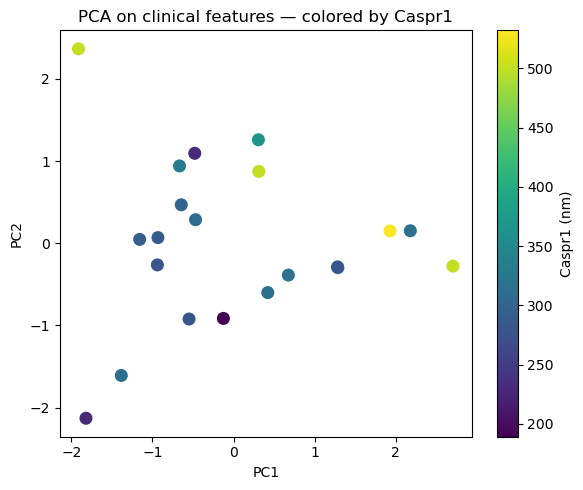

/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


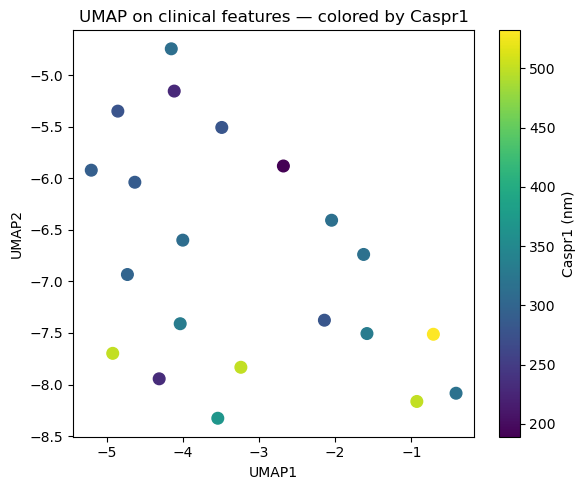

In [35]:
# === PCA & UMAP side-by-side on focused features ===
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# optional: umap
try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False

OUT = Path("../analysis/feature-analysis")
OUT.mkdir(parents=True, exist_ok=True)

feat_for_embedding = ["duration_months","npsi","ienfd_per_mm"]
assert set(feat_for_embedding + ["caspr1_mean_nm"]).issubset(df.columns)

# prep matrix (median-impute for viz only)
X = df[feat_for_embedding].copy()
X_imp = X.fillna(X.median(numeric_only=True))
X_scaled = StandardScaler().fit_transform(X_imp)

# --- PCA ---
pca = PCA(n_components=2, random_state=42)
pca_emb = pca.fit_transform(X_scaled)
pca_var = pca.explained_variance_ratio_
print(f"PCA explained variance: PC1={pca_var[0]:.2f}, PC2={pca_var[1]:.2f} (total={pca_var.sum():.2f})")

pca_df = pd.DataFrame(pca_emb, columns=["PC1","PC2"], index=df.index)
pca_df["caspr1_mean_nm"] = df["caspr1_mean_nm"]

plt.figure(figsize=(6,5))
sc = plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df["caspr1_mean_nm"], s=70)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA on clinical features — colored by Caspr1")
cb = plt.colorbar(sc); cb.set_label("Caspr1 (nm)")
plt.tight_layout()
plt.savefig(OUT/"pca_clinical_colored_by_caspr1.png", dpi=200)
plt.show()

# --- UMAP (if available) ---
if HAS_UMAP:
    reducer = umap.UMAP(n_neighbors=7, min_dist=0.3, random_state=42)
    umap_emb = reducer.fit_transform(X_scaled)
    umap_df = pd.DataFrame(umap_emb, columns=["UMAP1","UMAP2"], index=df.index)
    umap_df["caspr1_mean_nm"] = df["caspr1_mean_nm"]

    plt.figure(figsize=(6,5))
    sc = plt.scatter(umap_df["UMAP1"], umap_df["UMAP2"], c=umap_df["caspr1_mean_nm"], s=70)
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.title("UMAP on clinical features — colored by Caspr1")
    cb = plt.colorbar(sc); cb.set_label("Caspr1 (nm)")
    plt.tight_layout()
    plt.savefig(OUT/"umap_clinical_colored_by_caspr1.png", dpi=200)
    plt.show()
else:
    print("UMAP not installed — skip UMAP plot. Install with: mamba install -c conda-forge umap-learn")


## UMAP2 

### Robust scaling + Euclidean (UMAP & PCA)

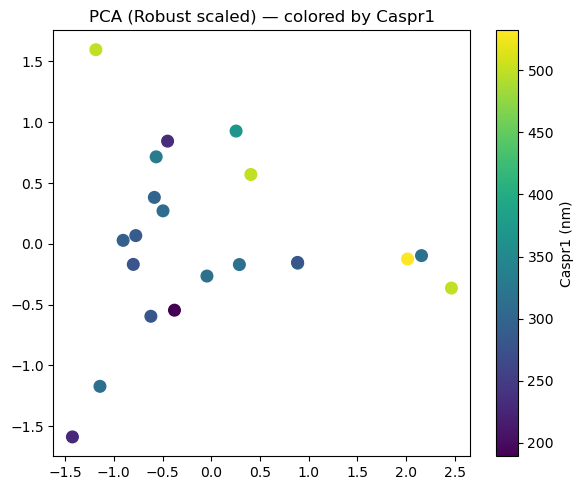

/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


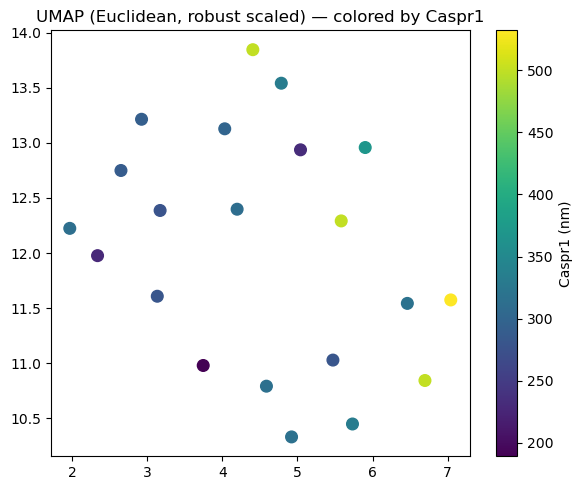

In [38]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

feat = ["duration_months","npsi","ienfd_per_mm"]
X = df[feat].copy()
X_imp = X.fillna(X.median(numeric_only=True))
X_rob = RobustScaler().fit_transform(X_imp)

# PCA
pca = PCA(n_components=2, random_state=42)
p_emb = pca.fit_transform(X_rob)

plt.figure(figsize=(6,5))
sc = plt.scatter(p_emb[:,0], p_emb[:,1], c=df["caspr1_mean_nm"], s=70)
plt.title("PCA (Robust scaled) — colored by Caspr1"); plt.colorbar(sc, label="Caspr1 (nm)")
plt.tight_layout(); plt.savefig(OUT/"pca_robust_caspr1.png", dpi=200); plt.show()

# UMAP
import umap
um = umap.UMAP(n_neighbors=7, min_dist=0.3, metric="euclidean", random_state=42)
u_emb = um.fit_transform(X_rob)

plt.figure(figsize=(6,5))
sc = plt.scatter(u_emb[:,0], u_emb[:,1], c=df["caspr1_mean_nm"], s=70)
plt.title("UMAP (Euclidean, robust scaled) — colored by Caspr1"); plt.colorbar(sc, label="Caspr1 (nm)")
plt.tight_layout(); plt.savefig(OUT/"umap_euclidean_robust_caspr1.png", dpi=200); plt.show()


### Rank transform (Spearman geometry) + Euclidean

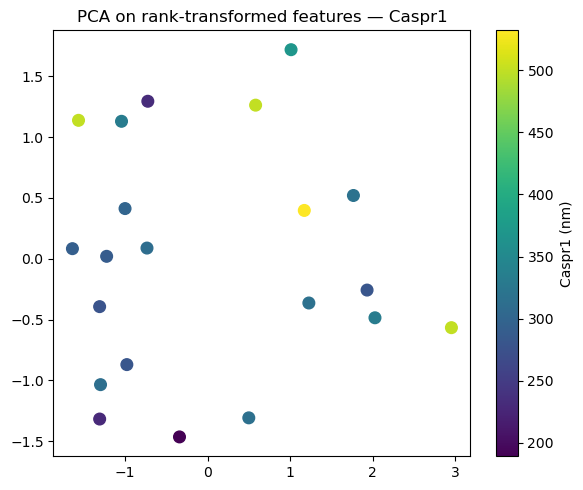

/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


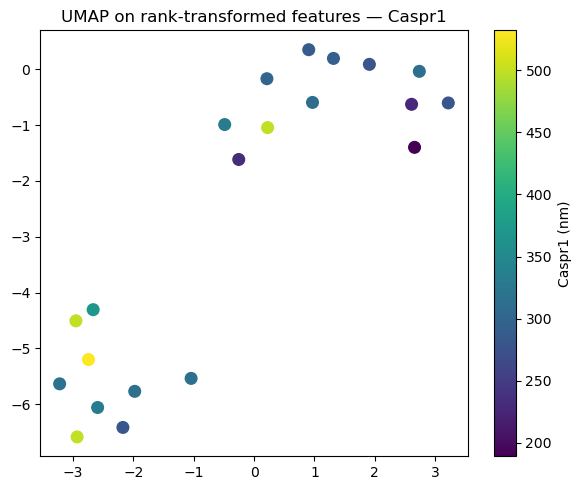

In [39]:
# rank-transform each feature (average ranks), then z-score
X_rank = X_imp.rank(method="average")
X_rank_z = (X_rank - X_rank.mean()) / X_rank.std(ddof=0)

# PCA
p_emb = PCA(n_components=2, random_state=42).fit_transform(X_rank_z)
plt.figure(figsize=(6,5))
sc = plt.scatter(p_emb[:,0], p_emb[:,1], c=df["caspr1_mean_nm"], s=70)
plt.title("PCA on rank-transformed features — Caspr1"); plt.colorbar(sc, label="Caspr1 (nm)")
plt.tight_layout(); plt.savefig(OUT/"pca_rank_caspr1.png", dpi=200); plt.show()

# UMAP
um = umap.UMAP(n_neighbors=7, min_dist=0.3, metric="euclidean", random_state=42)
u_emb = um.fit_transform(X_rank_z)
plt.figure(figsize=(6,5))
sc = plt.scatter(u_emb[:,0], u_emb[:,1], c=df["caspr1_mean_nm"], s=70)
plt.title("UMAP on rank-transformed features — Caspr1"); plt.colorbar(sc, label="Caspr1 (nm)")
plt.tight_layout(); plt.savefig(OUT/"umap_rank_caspr1.png", dpi=200); plt.show()


### Mahalanobis distance (UMAP)

/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


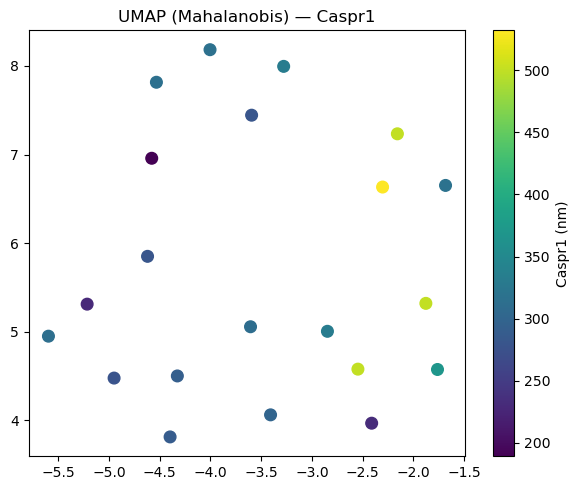

In [40]:
from sklearn.covariance import EmpiricalCovariance
Xz = (X_imp - X_imp.mean()) / X_imp.std(ddof=0)
cov = EmpiricalCovariance().fit(Xz)
VI = np.linalg.inv(cov.covariance_)  # inverse covariance

um = umap.UMAP(n_neighbors=7, min_dist=0.3, metric="mahalanobis", metric_kwds={"V": VI}, random_state=42)
u_emb = um.fit_transform(Xz)

plt.figure(figsize=(6,5))
sc = plt.scatter(u_emb[:,0], u_emb[:,1], c=df["caspr1_mean_nm"], s=70)
plt.title("UMAP (Mahalanobis) — Caspr1"); plt.colorbar(sc, label="Caspr1 (nm)")
plt.tight_layout(); plt.savefig(OUT/"umap_mahalanobis_caspr1.png", dpi=200); plt.show()


### Correlation / Cosine distance (UMAP)

/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


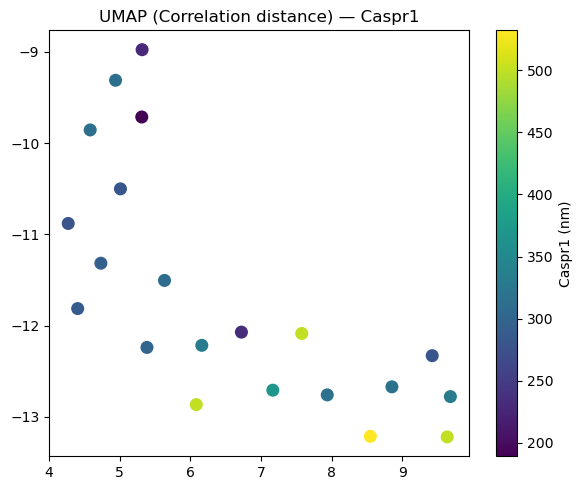

In [41]:
um = umap.UMAP(n_neighbors=7, min_dist=0.3, metric="correlation", random_state=42)
u_emb = um.fit_transform(X_imp)  # correlation metric is scale-invariant

plt.figure(figsize=(6,5))
sc = plt.scatter(u_emb[:,0], u_emb[:,1], c=df["caspr1_mean_nm"], s=70)
plt.title("UMAP (Correlation distance) — Caspr1"); plt.colorbar(sc, label="Caspr1 (nm)")
plt.tight_layout(); plt.savefig(OUT/"umap_correlation_caspr1.png", dpi=200); plt.show()


### Feature weighting by evidence (|ρ| with Caspr1)

/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


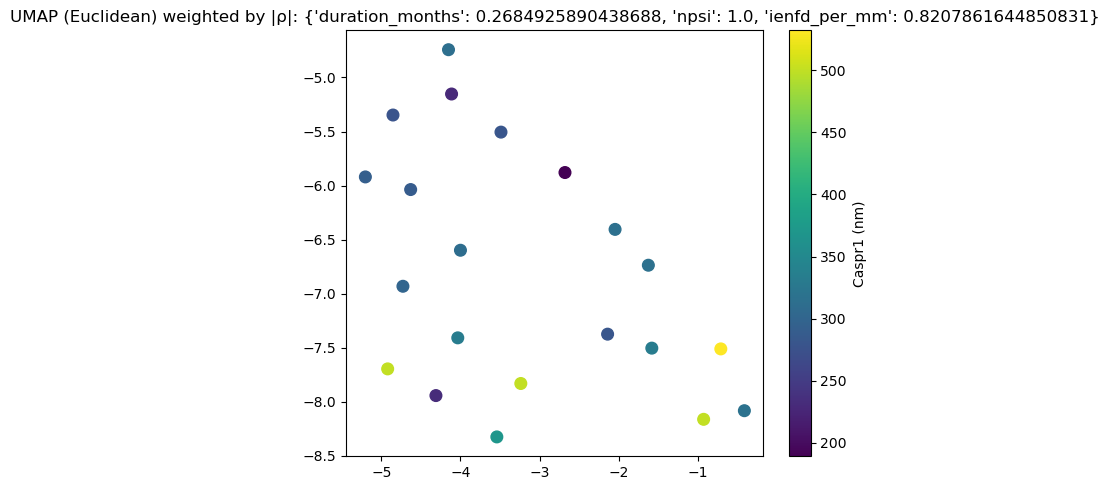

In [42]:
from scipy.stats import spearmanr

weights = {}
for f in ["duration_months","npsi","ienfd_per_mm"]:
    mask = df[f].notna() & df["caspr1_mean_nm"].notna()
    r, _ = spearmanr(df.loc[mask, f], df.loc[mask, "caspr1_mean_nm"])
    weights[f] = abs(r)

# avoid zeros; normalize
w = pd.Series(weights)
w = w.replace(0, w[w>0].min())  # if any zero
w = w / w.max()

Xw = X_imp.copy()
for f in Xw.columns:
    Xw[f] = Xw[f] * w[f]

um = umap.UMAP(n_neighbors=7, min_dist=0.3, metric="euclidean", random_state=42)
u_emb = um.fit_transform(StandardScaler().fit_transform(Xw))

plt.figure(figsize=(6,5))
sc = plt.scatter(u_emb[:,0], u_emb[:,1], c=df["caspr1_mean_nm"], s=70)
plt.title(f"UMAP (Euclidean) weighted by |ρ|: {w.to_dict()}"); plt.colorbar(sc, label="Caspr1 (nm)")
plt.tight_layout(); plt.savefig(OUT/"umap_weighted_by_rho_caspr1.png", dpi=200); plt.show()


### Gower distance (if you add categorical vars)

In [ ]:
mamba install -c conda-forge gower

In [43]:
import gower
cols = ["duration_months","npsi","ienfd_per_mm","sex","diabetes_type"]  # mixed
Xm = df[cols].copy()
Xm["sex"] = Xm["sex"].astype("category")
Xm["diabetes_type"] = Xm["diabetes_type"].astype("category")

D = gower.gower_matrix(Xm)  # NxN distance
um = umap.UMAP(n_neighbors=7, min_dist=0.3, metric="precomputed", random_state=42)
u_emb = um.fit_transform(D)

plt.figure(figsize=(6,5))
sc = plt.scatter(u_emb[:,0], u_emb[:,1], c=df["caspr1_mean_nm"], s=70)
plt.title("UMAP (Gower, mixed features) — Caspr1"); plt.colorbar(sc, label="Caspr1 (nm)")
plt.tight_layout(); plt.savefig(OUT/"umap_gower_caspr1.png", dpi=200); plt.show()


ModuleNotFoundError: No module named 'gower'

## Tiny decision tree (depth=2) on Caspr1 high/low using only NPSI + IENFD

In [25]:
from sklearn.pipeline import Pipeline

mask = df["caspr1_mean_nm"].notna() & df["npsi"].notna() & df["ienfd_per_mm"].notna()
X = df.loc[mask, ["npsi","ienfd_per_mm"]].copy()
y_cont = df.loc[mask, "caspr1_mean_nm"].astype(float)

# median split for "high" vs "low"
thr = y_cont.median()
y = (y_cont >= thr).astype(int)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42))
])

loo = LeaveOneOut()
y_prob = cross_val_predict(pipe, X, y, cv=loo, method="predict_proba")[:,1]
y_pred = (y_prob >= 0.5).astype(int)

try:
    auc = roc_auc_score(y, y_prob)
except:
    auc = np.nan
acc = accuracy_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

print(f"[Caspr1 high/low | features: NPSI+IENFD]  thr={thr:.2f}  AUC={auc:.3f}  Acc={acc:.2f}")
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# fit on all to read rules and thresholds (unscaled features inside tree)
tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42)
tree.fit(X, y)
rules_txt = export_text(tree, feature_names=["npsi","ienfd_per_mm"], decimals=2)
print("\nDecision tree rules:\n", rules_txt)

# save rules
with open(OUT/"caspr1_tree_rules_npsi_ienfd.txt","w") as f:
    f.write(f"Median threshold: {thr:.3f}\n")
    f.write(rules_txt)


[Caspr1 high/low | features: NPSI+IENFD]  thr=313.31  AUC=0.609  Acc=0.76
Confusion matrix (rows=true, cols=pred):
 [[8 2]
 [3 8]]

Decision tree rules:
 |--- ienfd_per_mm <= 2.85
|   |--- ienfd_per_mm <= 1.81
|   |   |--- class: 1
|   |--- ienfd_per_mm >  1.81
|   |   |--- class: 1
|--- ienfd_per_mm >  2.85
|   |--- ienfd_per_mm <= 7.78
|   |   |--- class: 0
|   |--- ienfd_per_mm >  7.78
|   |   |--- class: 0



In [44]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

OUT = Path("../analysis/feature-analysis")
OUT.mkdir(parents=True, exist_ok=True)

# -------------------------------
# Data slice (only rows with y & needed X present)
# -------------------------------
ycol = "caspr1_mean_nm"
thr = df[ycol].median()
mask_base = df[ycol].notna()

# Candidate feature sets to test
feature_sets = {
    "NPSI + IENFD": ["npsi", "ienfd_per_mm"],
    "NPSI + IENFD + age": ["npsi", "ienfd_per_mm", "age"],
    "NPSI + IENFD + duration": ["npsi", "ienfd_per_mm", "duration_months"],
    "NPSI + IENFD + age + duration": ["npsi", "ienfd_per_mm", "age", "duration_months"],
}

# Small grid of tree sizes (keep tiny!)
depth_grid = [1, 2, 3]
leaf_grid  = [2, 3]

rows = []

for name, feats in feature_sets.items():
    mask = mask_base.copy()
    for f in feats:
        mask &= df[f].notna()

    X = df.loc[mask, feats].copy()
    y_cont = df.loc[mask, ycol].astype(float)
    y = (y_cont >= thr).astype(int)

    # skip if too few samples
    if len(X) < 8:
        continue

    for depth in depth_grid:
        for leaf in leaf_grid:
            clf = DecisionTreeClassifier(
                max_depth=depth,
                min_samples_leaf=leaf,
                random_state=42
            )

            loo = LeaveOneOut()
            # Tree doesn't need scaling; directly LOOCV
            y_prob = cross_val_predict(clf, X, y, cv=loo, method="predict_proba")[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)

            # metrics
            try:
                auc = roc_auc_score(y, y_prob)
            except Exception:
                auc = np.nan
            acc = accuracy_score(y, y_pred)

            rows.append({
                "feature_set": name,
                "n_samples": len(X),
                "features": ",".join(feats),
                "max_depth": depth,
                "min_samples_leaf": leaf,
                "auc_loocv": auc,
                "acc_loocv": acc
            })

res = pd.DataFrame(rows).sort_values(
    ["auc_loocv", "acc_loocv", "max_depth"], ascending=[False, False, True]
).reset_index(drop=True)

display(res)
res.to_csv(OUT / "tree_loocv_model_selection.csv", index=False)
print(f"Saved model comparison → {OUT/'tree_loocv_model_selection.csv'}")

# -------------------------------
# Pick best (highest AUC, then Acc), fit final tree & print rules
# -------------------------------
if len(res):
    best = res.iloc[0]
    best_feats = feature_sets[best["feature_set"]]

    # Rebuild final X/y on all available rows for those features
    mask = mask_base.copy()
    for f in best_feats:
        mask &= df[f].notna()
    X_final = df.loc[mask, best_feats].copy()
    yc = df.loc[mask, ycol].astype(float)
    y_final = (yc >= thr).astype(int)

    final_tree = DecisionTreeClassifier(
        max_depth=int(best["max_depth"]),
        min_samples_leaf=int(best["min_samples_leaf"]),
        random_state=42
    )
    final_tree.fit(X_final, y_final)

    # LOOCV metrics printed again for the chosen set (sanity)
    loo = LeaveOneOut()
    y_prob = cross_val_predict(final_tree, X_final, y_final, cv=loo, method="predict_proba")[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    try:
        best_auc = roc_auc_score(y_final, y_prob)
    except:
        best_auc = np.nan
    best_acc = accuracy_score(y_final, y_pred)
    cm = confusion_matrix(y_final, y_pred)

    print("\n=== FINAL MODEL (fitted on all data with best settings) ===")
    print(f"Feature set: {best['feature_set']}  |  n={len(X_final)}")
    print(f"max_depth={int(best['max_depth'])}, min_samples_leaf={int(best['min_samples_leaf'])}")
    print(f"LOOCV AUC={best_auc:.3f}, Acc={best_acc:.2f}")
    print("Confusion matrix (rows=true, cols=pred):\n", cm)

    # Human-readable rules (real thresholds, no scaling)
    rules_txt = export_text(final_tree, feature_names=list(best_feats), decimals=2)
    print("\nDecision tree rules:\n", rules_txt)

    # Save rules
    rules_file = OUT / "caspr1_tree_rules_best.txt"
    with open(rules_file, "w") as f:
        f.write(f"Caspr1 median threshold: {thr:.3f}\n")
        f.write(f"Feature set: {best['feature_set']} (n={len(X_final)})\n")
        f.write(f"max_depth={int(best['max_depth'])}, min_samples_leaf={int(best['min_samples_leaf'])}\n")
        f.write(f"LOOCV AUC={best_auc:.3f}, Acc={best_acc:.2f}\n\n")
        f.write(rules_txt)
    print(f"Saved rules → {rules_file}")

else:
    print("No valid models (not enough complete rows).")


,feature_set,n_samples,features,max_depth,min_samples_leaf,auc_loocv,acc_loocv
0,NPSI + IENFD,21,"npsi,ienfd_per_mm",1,2,0.654545,0.714286
1,NPSI + IENFD,21,"npsi,ienfd_per_mm",1,3,0.654545,0.714286
2,NPSI + IENFD + age,21,"npsi,ienfd_per_mm,age",1,2,0.654545,0.714286
3,NPSI + IENFD + age,21,"npsi,ienfd_per_mm,age",1,3,0.654545,0.714286
4,NPSI + IENFD + duration,21,"npsi,ienfd_per_mm,duration_months",1,2,0.654545,0.714286
5,NPSI + IENFD + duration,21,"npsi,ienfd_per_mm,duration_months",1,3,0.654545,0.714286
6,NPSI + IENFD + age + duration,21,"npsi,ienfd_per_mm,age,duration_months",1,2,0.654545,0.714286
7,NPSI + IENFD + age + duration,21,"npsi,ienfd_per_mm,age,duration_months",1,3,0.654545,0.714286
8,NPSI + IENFD + duration,21,"npsi,ienfd_per_mm,duration_months",3,2,0.622727,0.523810
9,NPSI + IENFD,21,"npsi,ienfd_per_mm",2,2,0.609091,0.761905


Saved model comparison → ../analysis/feature-analysis/tree_loocv_model_selection.csv

=== FINAL MODEL (fitted on all data with best settings) ===
Feature set: NPSI + IENFD  |  n=21
max_depth=1, min_samples_leaf=2
LOOCV AUC=0.655, Acc=0.71
Confusion matrix (rows=true, cols=pred):
 [[8 2]
 [4 7]]

Decision tree rules:
 |--- ienfd_per_mm <= 2.85
|   |--- class: 1
|--- ienfd_per_mm >  2.85
|   |--- class: 0

Saved rules → ../analysis/feature-analysis/caspr1_tree_rules_best.txt


# Find clinical cutoff values for being highly predictive 

In [45]:
# === Predictive cutoffs for clinical features via ROC + Youden's J, with bootstrap CIs ===
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score

OUT = Path("../analysis/feature-analysis")
OUT.mkdir(parents=True, exist_ok=True)

# Choose which periodicity targets to analyze (start with Caspr1)
TARGETS = ["caspr1_mean_nm"]  # or: ["nf155_mean_nm","nf186_mean_nm","caspr1_mean_nm"]

# Clinical features to evaluate as single-variable predictors
FEATURES = [
    "diabetes_type","age","sex","duration_months","snap_sural_nerve",
    "hba1c_pct","nis_ll","sas","npsi","ienfd_per_mm","n_nodes_examined"
]
FEATURES = [f for f in FEATURES if f in df.columns]  # keep only those present

# --- helper: compute single-feature ROC / Youden cutoff on one dataset slice ---
def youden_cutoff(y_true, x_score):
    """Return threshold that maximizes Youden's J, and its sens/spec/AUC.
       y_true must be binary {0,1}; x_score numeric (higher = more likely positive is fine).
    """
    # Ensure arrays, drop NaNs together
    mask = (~pd.isna(y_true)) & (~pd.isna(x_score))
    y = np.asarray(y_true[mask], dtype=int)
    x = np.asarray(x_score[mask], dtype=float)

    # Need both classes
    if len(np.unique(y)) < 2 or len(y) < 8:
        return np.nan, np.nan, np.nan, np.nan, mask.sum()

    fpr, tpr, thr = roc_curve(y, x)
    youden = tpr - fpr
    idx = np.argmax(youden)
    cutoff = thr[idx]
    sens = tpr[idx]
    spec = 1 - fpr[idx]
    try:
        auc = roc_auc_score(y, x)
    except Exception:
        auc = np.nan
    return cutoff, sens, spec, auc, mask.sum()

# --- helper: pick the side of the threshold ("x >= thr" vs "x <= thr") for a human-readable rule ---
def choose_rule_direction(y_true, x_feature, thr):
    """Return ('>=', 'higher→positive') or ('<=', 'lower→positive') depending on class-conditional means."""
    mask = (~pd.isna(y_true)) & (~pd.isna(x_feature))
    y = np.asarray(y_true[mask], dtype=int)
    x = np.asarray(x_feature[mask], dtype=float)

    if y.mean() == 0 or y.mean() == 1 or np.isnan(thr):
        return ">=", "higher→positive"

    mean_pos = x[y == 1].mean()
    mean_neg = x[y == 0].mean()
    if mean_pos >= mean_neg:
        # positives tend to have higher x → use x >= thr predicts positive
        return ">=", "higher→positive"
    else:
        # positives tend to have lower x → use x <= thr predicts positive
        return "<=", "lower→positive"

# --- helper: bootstrap CIs for cutoff, sens, spec, AUC ---
rng = np.random.default_rng(42)
def bootstrap_metrics(y_true, x_feature, B=2000):
    mask = (~pd.isna(y_true)) & (~pd.isna(x_feature))
    y = np.asarray(y_true[mask], dtype=int)
    x = np.asarray(x_feature[mask], dtype=float)

    if len(np.unique(y)) < 2 or len(y) < 8:
        return {k: (np.nan, np.nan, np.nan) for k in ["cutoff","sens","spec","auc"]}

    N = len(y)
    cut_list, sens_list, spec_list, auc_list = [], [], [], []
    for _ in range(B):
        idx = rng.integers(0, N, size=N)
        yb = y[idx]
        xb = x[idx]
        # require both classes in bootstrap sample
        if len(np.unique(yb)) < 2:
            continue
        fpr, tpr, thr = roc_curve(yb, xb)
        J = tpr - fpr
        jdx = np.argmax(J)
        cut_list.append(thr[jdx])
        sens_list.append(tpr[jdx])
        spec_list.append(1 - fpr[jdx])
        try:
            auc_list.append(roc_auc_score(yb, xb))
        except Exception:
            pass

    def ci(v):
        v = np.array(v, dtype=float)
        v = v[~np.isnan(v)]
        if len(v) == 0:
            return (np.nan, np.nan, np.nan)
        return (np.median(v), np.percentile(v, 2.5), np.percentile(v, 97.5))

    return {
        "cutoff": ci(cut_list),
        "sens":   ci(sens_list),
        "spec":   ci(spec_list),
        "auc":    ci(auc_list),
    }

# === main loop over targets and features ===
all_rows = []
for target in TARGETS:
    # Define binary outcome by median split (high vs low periodicity)
    if target not in df.columns:
        continue
    y_cont = df[target].astype(float)
    thr_target = np.nanmedian(y_cont)
    y_bin = (y_cont >= thr_target).astype(int)

    for feat in FEATURES:
        cutoff, sens, spec, auc, n_used = youden_cutoff(y_bin, df[feat])
        direction_symbol, direction_text = choose_rule_direction(y_bin, df[feat], cutoff)
        boot = bootstrap_metrics(y_bin, df[feat], B=2000)

        # unpack bootstrap tuples: (median, low, high)
        cut_med, cut_lo, cut_hi = boot["cutoff"]
        sens_med, sens_lo, sens_hi = boot["sens"]
        spec_med, spec_lo, spec_hi = boot["spec"]
        auc_med,  auc_lo,  auc_hi  = boot["auc"]

        all_rows.append({
            "target": target,
            "positive_class_definition": f">= median ({thr_target:.2f} nm)",
            "feature": feat,
            "n_used": n_used,
            "rule_direction": direction_text,
            "point_cutoff": None if np.isnan(cutoff) else round(float(cutoff), 3),
            "point_sensitivity": None if np.isnan(sens) else round(float(sens), 3),
            "point_specificity": None if np.isnan(spec) else round(float(spec), 3),
            "point_auc": None if np.isnan(auc) else round(float(auc), 3),
            "boot_cutoff_median": None if np.isnan(cut_med) else round(float(cut_med), 3),
            "boot_cutoff_2.5%": None if np.isnan(cut_lo) else round(float(cut_lo), 3),
            "boot_cutoff_97.5%": None if np.isnan(cut_hi) else round(float(cut_hi), 3),
            "boot_sens_median": None if np.isnan(sens_med) else round(float(sens_med), 3),
            "boot_sens_2.5%": None if np.isnan(sens_lo) else round(float(sens_lo), 3),
            "boot_sens_97.5%": None if np.isnan(sens_hi) else round(float(sens_hi), 3),
            "boot_spec_median": None if np.isnan(spec_med) else round(float(spec_med), 3),
            "boot_spec_2.5%": None if np.isnan(spec_lo) else round(float(spec_lo), 3),
            "boot_spec_97.5%": None if np.isnan(spec_hi) else round(float(spec_hi), 3),
            "boot_auc_median": None if np.isnan(auc_med) else round(float(auc_med), 3),
            "boot_auc_2.5%": None if np.isnan(auc_lo) else round(float(auc_lo), 3),
            "boot_auc_97.5%": None if np.isnan(auc_hi) else round(float(auc_hi), 3),
            "human_readable_rule": (
                "x {} {:.3f} → predict HIGH".format(">=" if direction_symbol==">=" else "<=", 
                                                    cutoff if not np.isnan(cutoff) else float('nan'))
            )
        })

# Build and save the table
cutoffs_df = pd.DataFrame(all_rows)
# Sort by target then by bootstrap AUC (median) descending
cutoffs_df = cutoffs_df.sort_values(
    ["target","boot_auc_median","point_auc"], ascending=[True, False, False]
).reset_index(drop=True)

display(cutoffs_df)
cutoffs_df.to_csv(OUT / "cutoffs_summary.csv", index=False)
print(f"Saved: {OUT/'cutoffs_summary.csv'}")


/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/job37yv/miniforge3/envs/neuro-ana/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/job37yv/miniforge3/envs/neuro-ana/lib/python

,target,positive_class_definition,feature,n_used,rule_direction,point_cutoff,point_sensitivity,point_specificity,point_auc,boot_cutoff_median,...,boot_sens_median,boot_sens_2.5%,boot_sens_97.5%,boot_spec_median,boot_spec_2.5%,boot_spec_97.5%,boot_auc_median,boot_auc_2.5%,boot_auc_97.5%,human_readable_rule
0,caspr1_mean_nm,>= median (313.31 nm),npsi,21,higher→positive,5.0,0.636,0.9,0.773,5.0,...,0.636,0.250,0.909,0.917,0.714,1.0,0.779,0.578,0.938,x >= 5.000 → predict HIGH
1,caspr1_mean_nm,>= median (313.31 nm),nis_ll,21,higher→positive,2.0,0.818,0.5,0.609,3.0,...,0.727,0.133,1.000,0.750,0.364,1.0,0.616,0.350,0.845,x >= 2.000 → predict HIGH
2,caspr1_mean_nm,>= median (313.31 nm),age,21,higher→positive,55.0,1.000,0.3,0.536,56.0,...,1.000,0.167,1.000,0.455,0.143,1.0,0.541,0.254,0.788,x >= 55.000 → predict HIGH
3,caspr1_mean_nm,>= median (313.31 nm),sas,21,higher→positive,17.0,0.273,1.0,0.523,17.0,...,0.357,0.083,0.929,1.000,0.333,1.0,0.528,0.265,0.782,x >= 17.000 → predict HIGH
4,caspr1_mean_nm,>= median (313.31 nm),hba1c_pct,21,higher→positive,6.1,0.909,0.3,0.509,6.2,...,0.833,0.000,1.000,0.500,0.143,1.0,0.500,0.241,0.769,x >= 6.100 → predict HIGH
5,caspr1_mean_nm,>= median (313.31 nm),diabetes_type,21,higher→positive,2.0,0.909,0.1,0.505,inf,...,0.000,0.000,1.000,1.000,0.083,1.0,0.500,0.385,0.633,x >= 2.000 → predict HIGH
6,caspr1_mean_nm,>= median (313.31 nm),duration_months,21,higher→positive,156.0,0.364,0.9,0.468,156.0,...,0.385,0.000,0.857,0.923,0.416,1.0,0.472,0.205,0.718,x >= 156.000 → predict HIGH
7,caspr1_mean_nm,>= median (313.31 nm),sex,21,lower→positive,inf,0.000,1.0,0.459,inf,...,0.000,0.000,1.000,1.000,0.091,1.0,0.462,0.316,0.611,x <= inf → predict HIGH
8,caspr1_mean_nm,>= median (313.31 nm),n_nodes_examined,21,lower→positive,inf,0.000,1.0,0.341,inf,...,0.000,0.000,0.833,1.000,0.300,1.0,0.337,0.139,0.586,x <= inf → predict HIGH
9,caspr1_mean_nm,>= median (313.31 nm),snap_sural_nerve,21,lower→positive,inf,0.000,1.0,0.341,6.5,...,0.323,0.000,0.909,0.857,0.200,1.0,0.333,0.120,0.618,x <= inf → predict HIGH


Saved: ../analysis/feature-analysis/cutoffs_summary.csv


# Fixed decsion tree 

In [46]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut, cross_val_predict
import numpy as np
import pandas as pd

# Features and pre-defined cutoffs
cut_features = {
    "npsi": 5.0,
    "nis_ll": 2.5,       # around 2–3
    "ienfd_per_mm": 2.8
}

# Create binary features based on these cutoffs
X_bin = pd.DataFrame()
for feat, thr in cut_features.items():
    X_bin[f"{feat}_high"] = (df[feat] >= thr).astype(int)

# Target: Caspr1 high vs low
y_cont = df["caspr1_mean_nm"].astype(float)
thr_caspr = y_cont.median()
y = (y_cont >= thr_caspr).astype(int)

# Decision tree (very shallow)
tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42)

loo = LeaveOneOut()
y_prob = cross_val_predict(tree, X_bin, y, cv=loo, method="predict_proba")[:,1]
y_pred = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y, y_prob)
acc = accuracy_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

print(f"[Caspr1 cutoffs tree] AUC={auc:.3f}, Acc={acc:.2f}")
print("Confusion matrix:\n", cm)

# Fit on all data to extract rules
tree.fit(X_bin, y)
rules = export_text(tree, feature_names=list(X_bin.columns))
print("\nDecision tree rules:\n", rules)


[Caspr1 cutoffs tree] AUC=0.655, Acc=0.81
Confusion matrix:
 [[8 2]
 [2 9]]

Decision tree rules:
 |--- ienfd_per_mm_high <= 0.50
|   |--- nis_ll_high <= 0.50
|   |   |--- class: 1
|   |--- nis_ll_high >  0.50
|   |   |--- class: 1
|--- ienfd_per_mm_high >  0.50
|   |--- nis_ll_high <= 0.50
|   |   |--- class: 0
|   |--- nis_ll_high >  0.50
|   |   |--- class: 0



In [48]:
from itertools import combinations
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd

cut_features = {
    "npsi": 5.0,
    "ienfd_per_mm": 2.8,
    "nis_ll": 2.5,
    "age": 55,
    "sex": 0.5,                 # assume encoded 0/1
    "duration_months": 150
}

# Build binary cutoff dataframe
X_bin = pd.DataFrame()
for feat, thr in cut_features.items():
    if feat == "sex":
        X_bin[f"{feat}_high"] = (df[feat] == 1).astype(int)
    else:
        X_bin[f"{feat}_high"] = (df[feat] >= thr).astype(int)

# Target (Caspr1 high vs low by median)
y_cont = df["caspr1_mean_nm"].astype(float)
thr_caspr = y_cont.median()
y = (y_cont >= thr_caspr).astype(int)

loo = LeaveOneOut()
results = []

for k in [1,2,3]:
    for feats in combinations(X_bin.columns, k):
        X_sub = X_bin[list(feats)]

        tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42)
        y_prob = cross_val_predict(tree, X_sub, y, cv=loo, method="predict_proba")[:,1]
        y_pred = (y_prob >= 0.5).astype(int)

        auc = roc_auc_score(y, y_prob)
        acc = accuracy_score(y, y_pred)

        tree.fit(X_sub, y)
        rules = export_text(tree, feature_names=list(feats))

        results.append({
            "n_features": k,
            "features": ",".join(feats),
            "AUC": auc,
            "Accuracy": acc,
            "Rules": rules
        })

res_df = pd.DataFrame(results).sort_values("AUC", ascending=False)
res_df.to_csv(OUT/"decision_tree_cutoff_comparison.csv", index=False)
display(res_df.head(30))


,n_features,features,AUC,Accuracy,Rules
12,2,"ienfd_per_mm_high,age_high",0.709091,0.809524,|--- ienfd_per_mm_high <= 0.50\n| |--- class...
35,3,"ienfd_per_mm_high,age_high,duration_months_high",0.709091,0.809524,|--- ienfd_per_mm_high <= 0.50\n| |--- durat...
25,3,"npsi_high,nis_ll_high,age_high",0.681818,0.761905,|--- npsi_high <= 0.50\n| |--- age_high <= 0...
31,3,"ienfd_per_mm_high,nis_ll_high,age_high",0.681818,0.809524,|--- ienfd_per_mm_high <= 0.50\n| |--- nis_l...
28,3,"npsi_high,age_high,sex_high",0.681818,0.761905,|--- npsi_high <= 0.50\n| |--- age_high <= 0...
34,3,"ienfd_per_mm_high,age_high,sex_high",0.681818,0.809524,|--- ienfd_per_mm_high <= 0.50\n| |--- class...
8,2,"npsi_high,age_high",0.681818,0.761905,|--- npsi_high <= 0.50\n| |--- age_high <= 0...
22,3,"npsi_high,ienfd_per_mm_high,age_high",0.663636,0.714286,|--- ienfd_per_mm_high <= 0.50\n| |--- npsi_...
6,2,"npsi_high,ienfd_per_mm_high",0.654545,0.809524,|--- ienfd_per_mm_high <= 0.50\n| |--- npsi_...
27,3,"npsi_high,nis_ll_high,duration_months_high",0.654545,0.809524,|--- npsi_high <= 0.50\n| |--- duration_mont...


In [ ]:
# create a table periodicity x axis and y one feature 